In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import zscore

## Growing Season SPEI vs. Percent Forest Loss

In [3]:
# load data
spei_df = pd.read_csv('district_province_spei_stats.csv')

# rename season_year column for compatability with forest loss
spei_df = spei_df.rename(columns={'season_year': 'year', 'mean_growing_spei': 'mean_spei', 'median_growing_spei': 'median_spei'})

# load forest loss data
forest_df = pd.read_csv('district_forest_cover.csv')
forest_df['year'] = forest_df['year'].astype(int)

In [4]:
forest_df.head()

,district,year,forest_cover_ha,loss_m2,percent_loss_annual
0,Chadiza,2001,57181.013721,5.136993e+05,0.089757
1,Chadiza,2002,57127.207503,5.380622e+05,0.094098
2,Chadiza,2003,56960.977318,1.662302e+06,0.290983
3,Chadiza,2004,56773.795452,1.871819e+06,0.328614
4,Chadiza,2005,56703.324923,7.047053e+05,0.124125


In [4]:
# merge SPEI and forest data
merged_df = pd.merge(spei_df, forest_df, on=['district', 'year'])
merged_df.head()

,Unnamed: 0.1,Unnamed: 0,district,year,mean_spei,median_spei,n_months,province,province_avg_start_date,province_avg_end_date,forest_cover_ha,loss_m2,percent_loss_annual
0,1,1,Chadiza,2001,0.353488,0.303945,6,Eastern,November 26,May 04,57181.013721,5.136993e+05,0.089757
1,2,2,Chadiza,2002,0.281255,0.244052,6,Eastern,November 26,May 04,57127.207503,5.380622e+05,0.094098
2,3,3,Chadiza,2003,0.227219,0.217295,5,Eastern,November 26,May 04,56960.977318,1.662302e+06,0.290983
3,4,4,Chadiza,2004,0.025194,0.084612,6,Eastern,November 26,May 04,56773.795452,1.871819e+06,0.328614
4,5,5,Chadiza,2005,-0.712003,-0.763748,5,Eastern,November 26,May 04,56703.324923,7.047053e+05,0.124125


Lag 1: 1380 rows


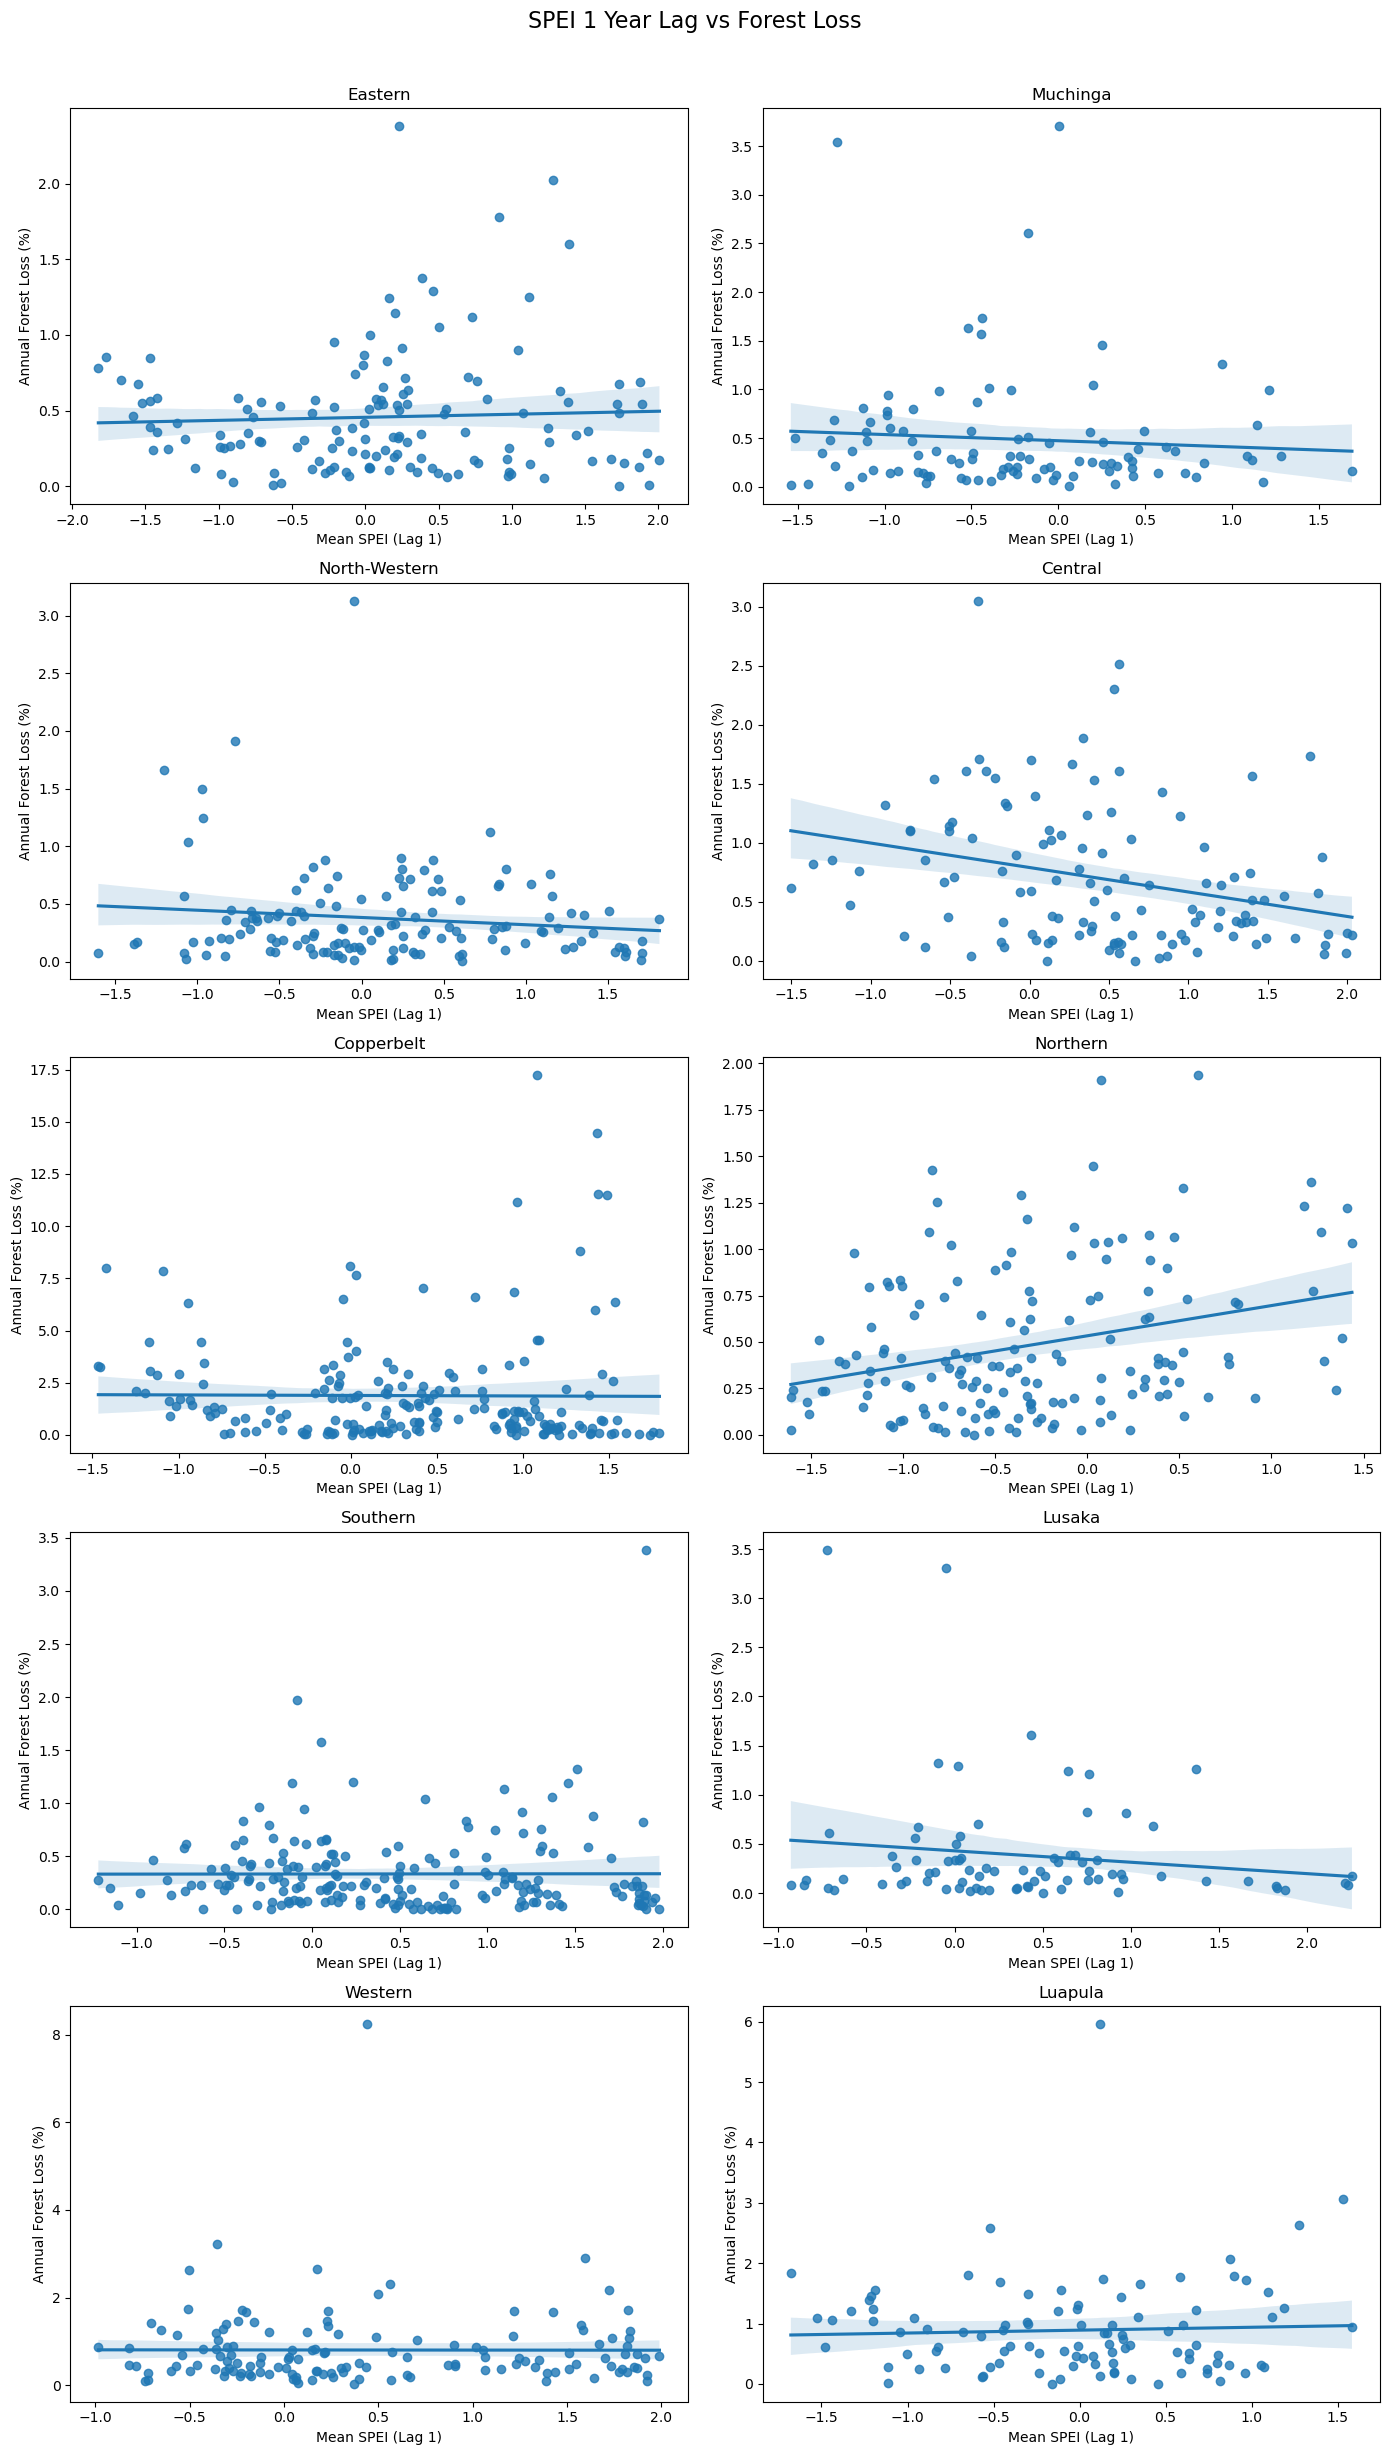

Lag 2: 1311 rows


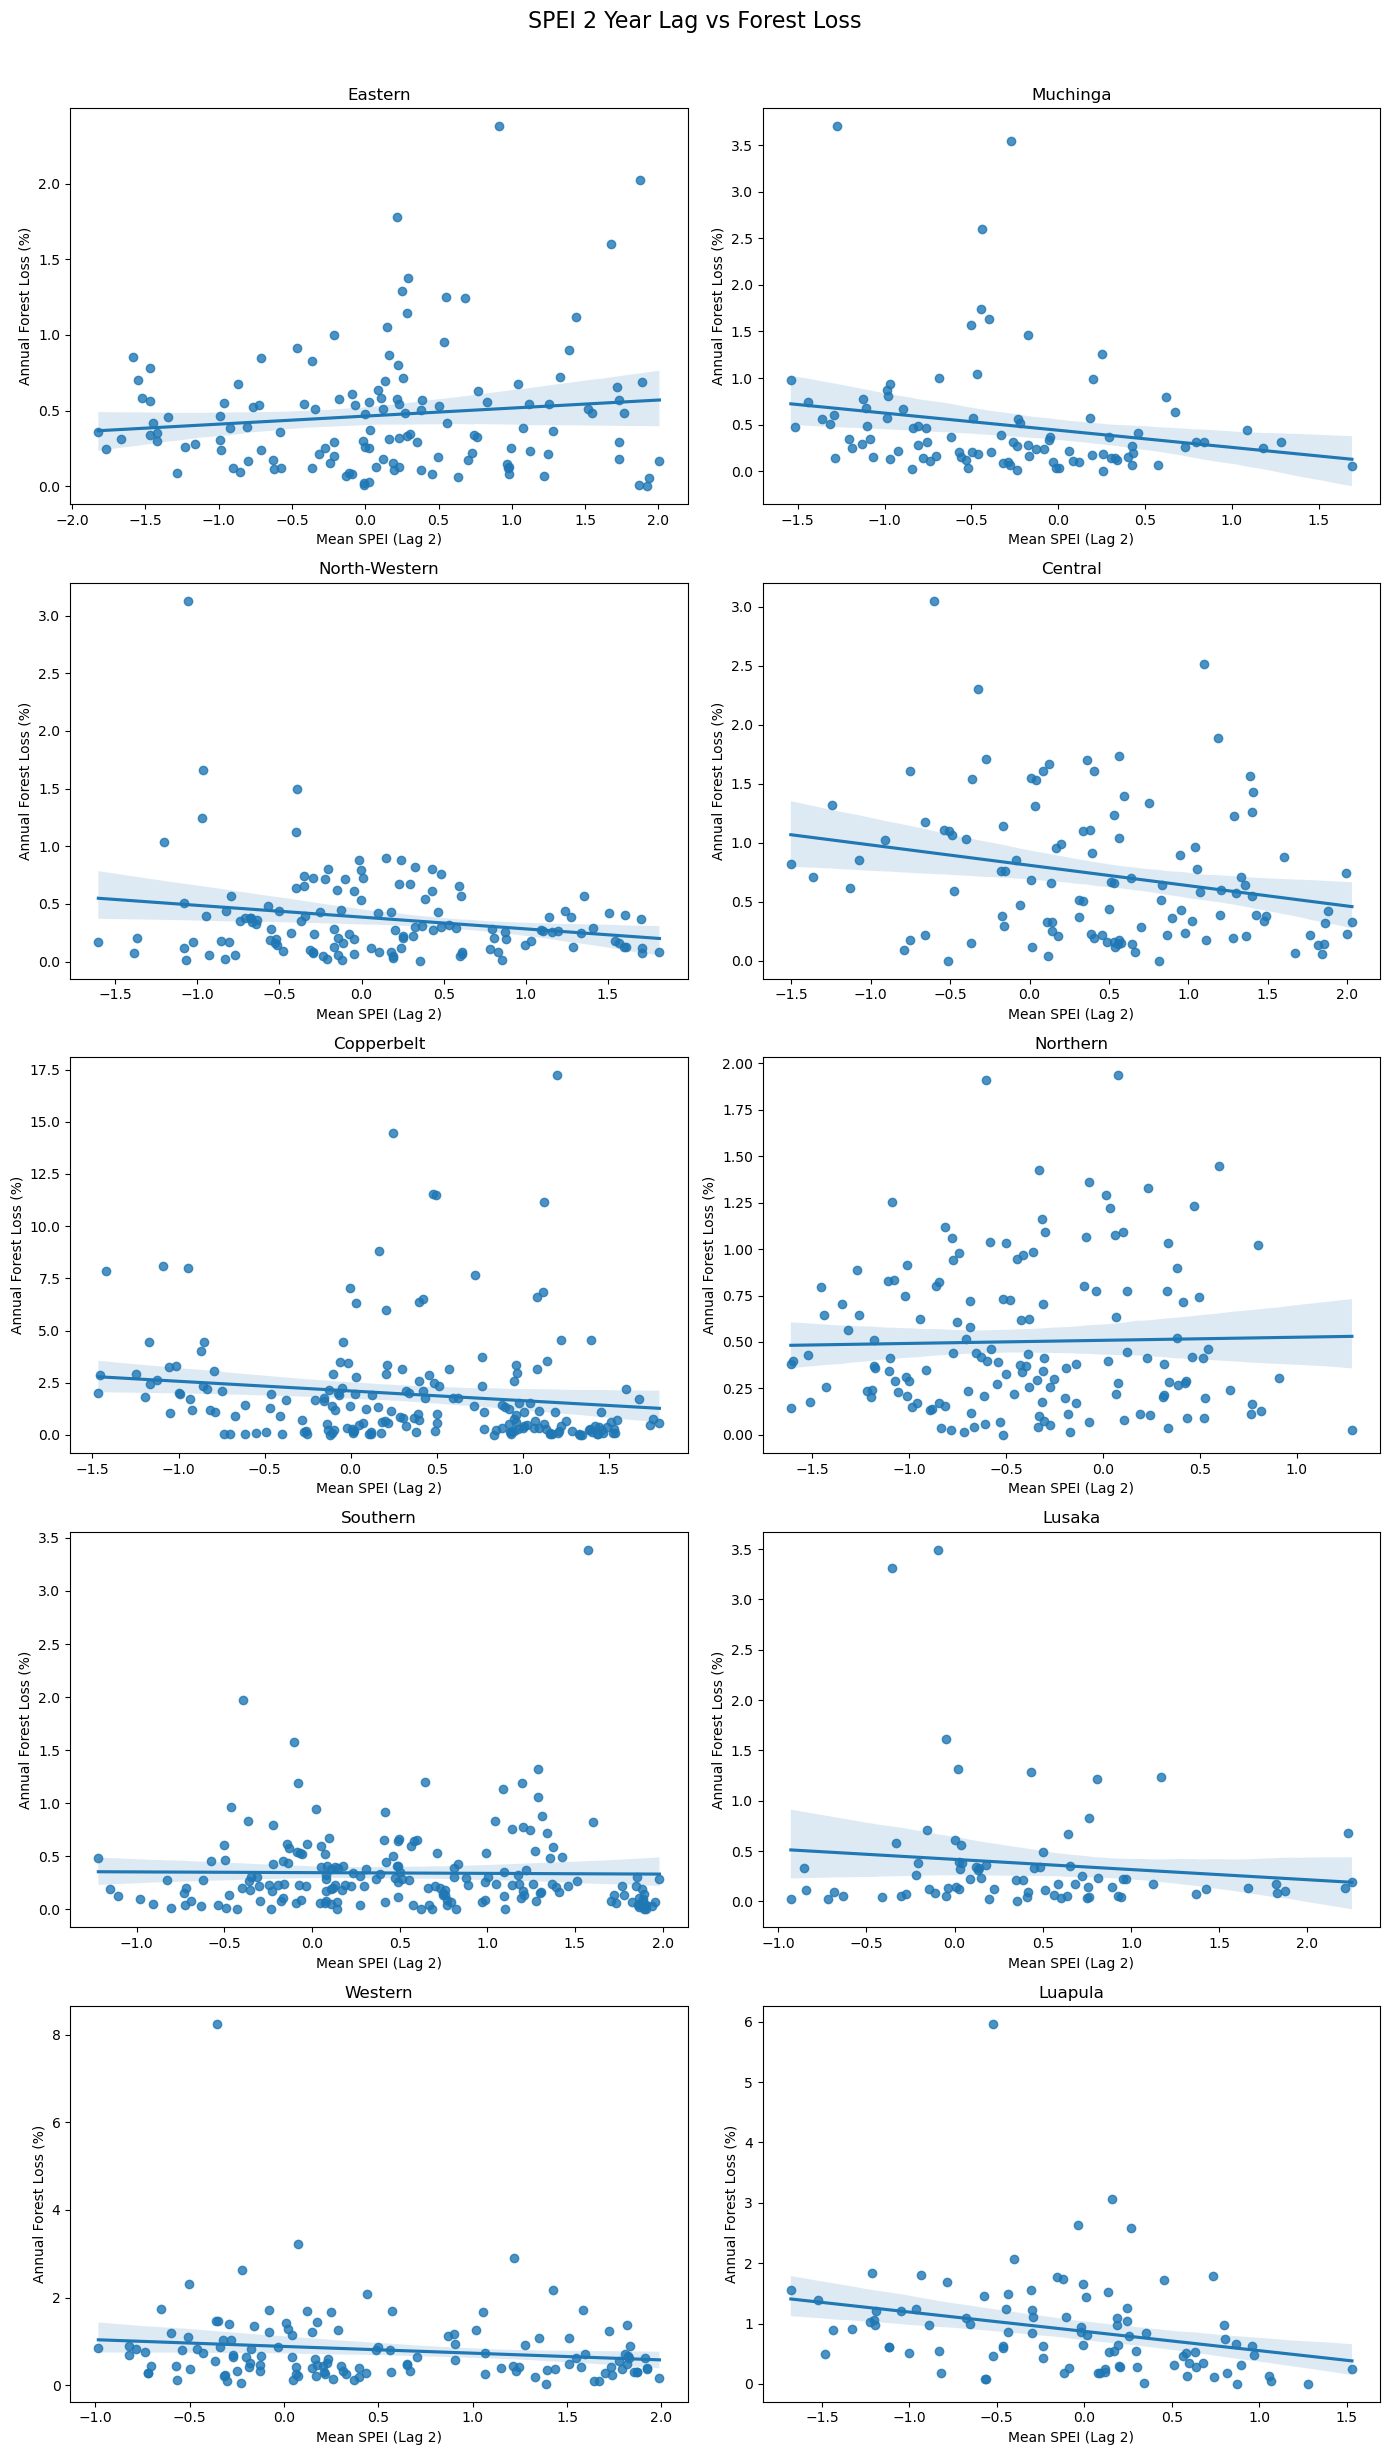

Lag 3: 1242 rows


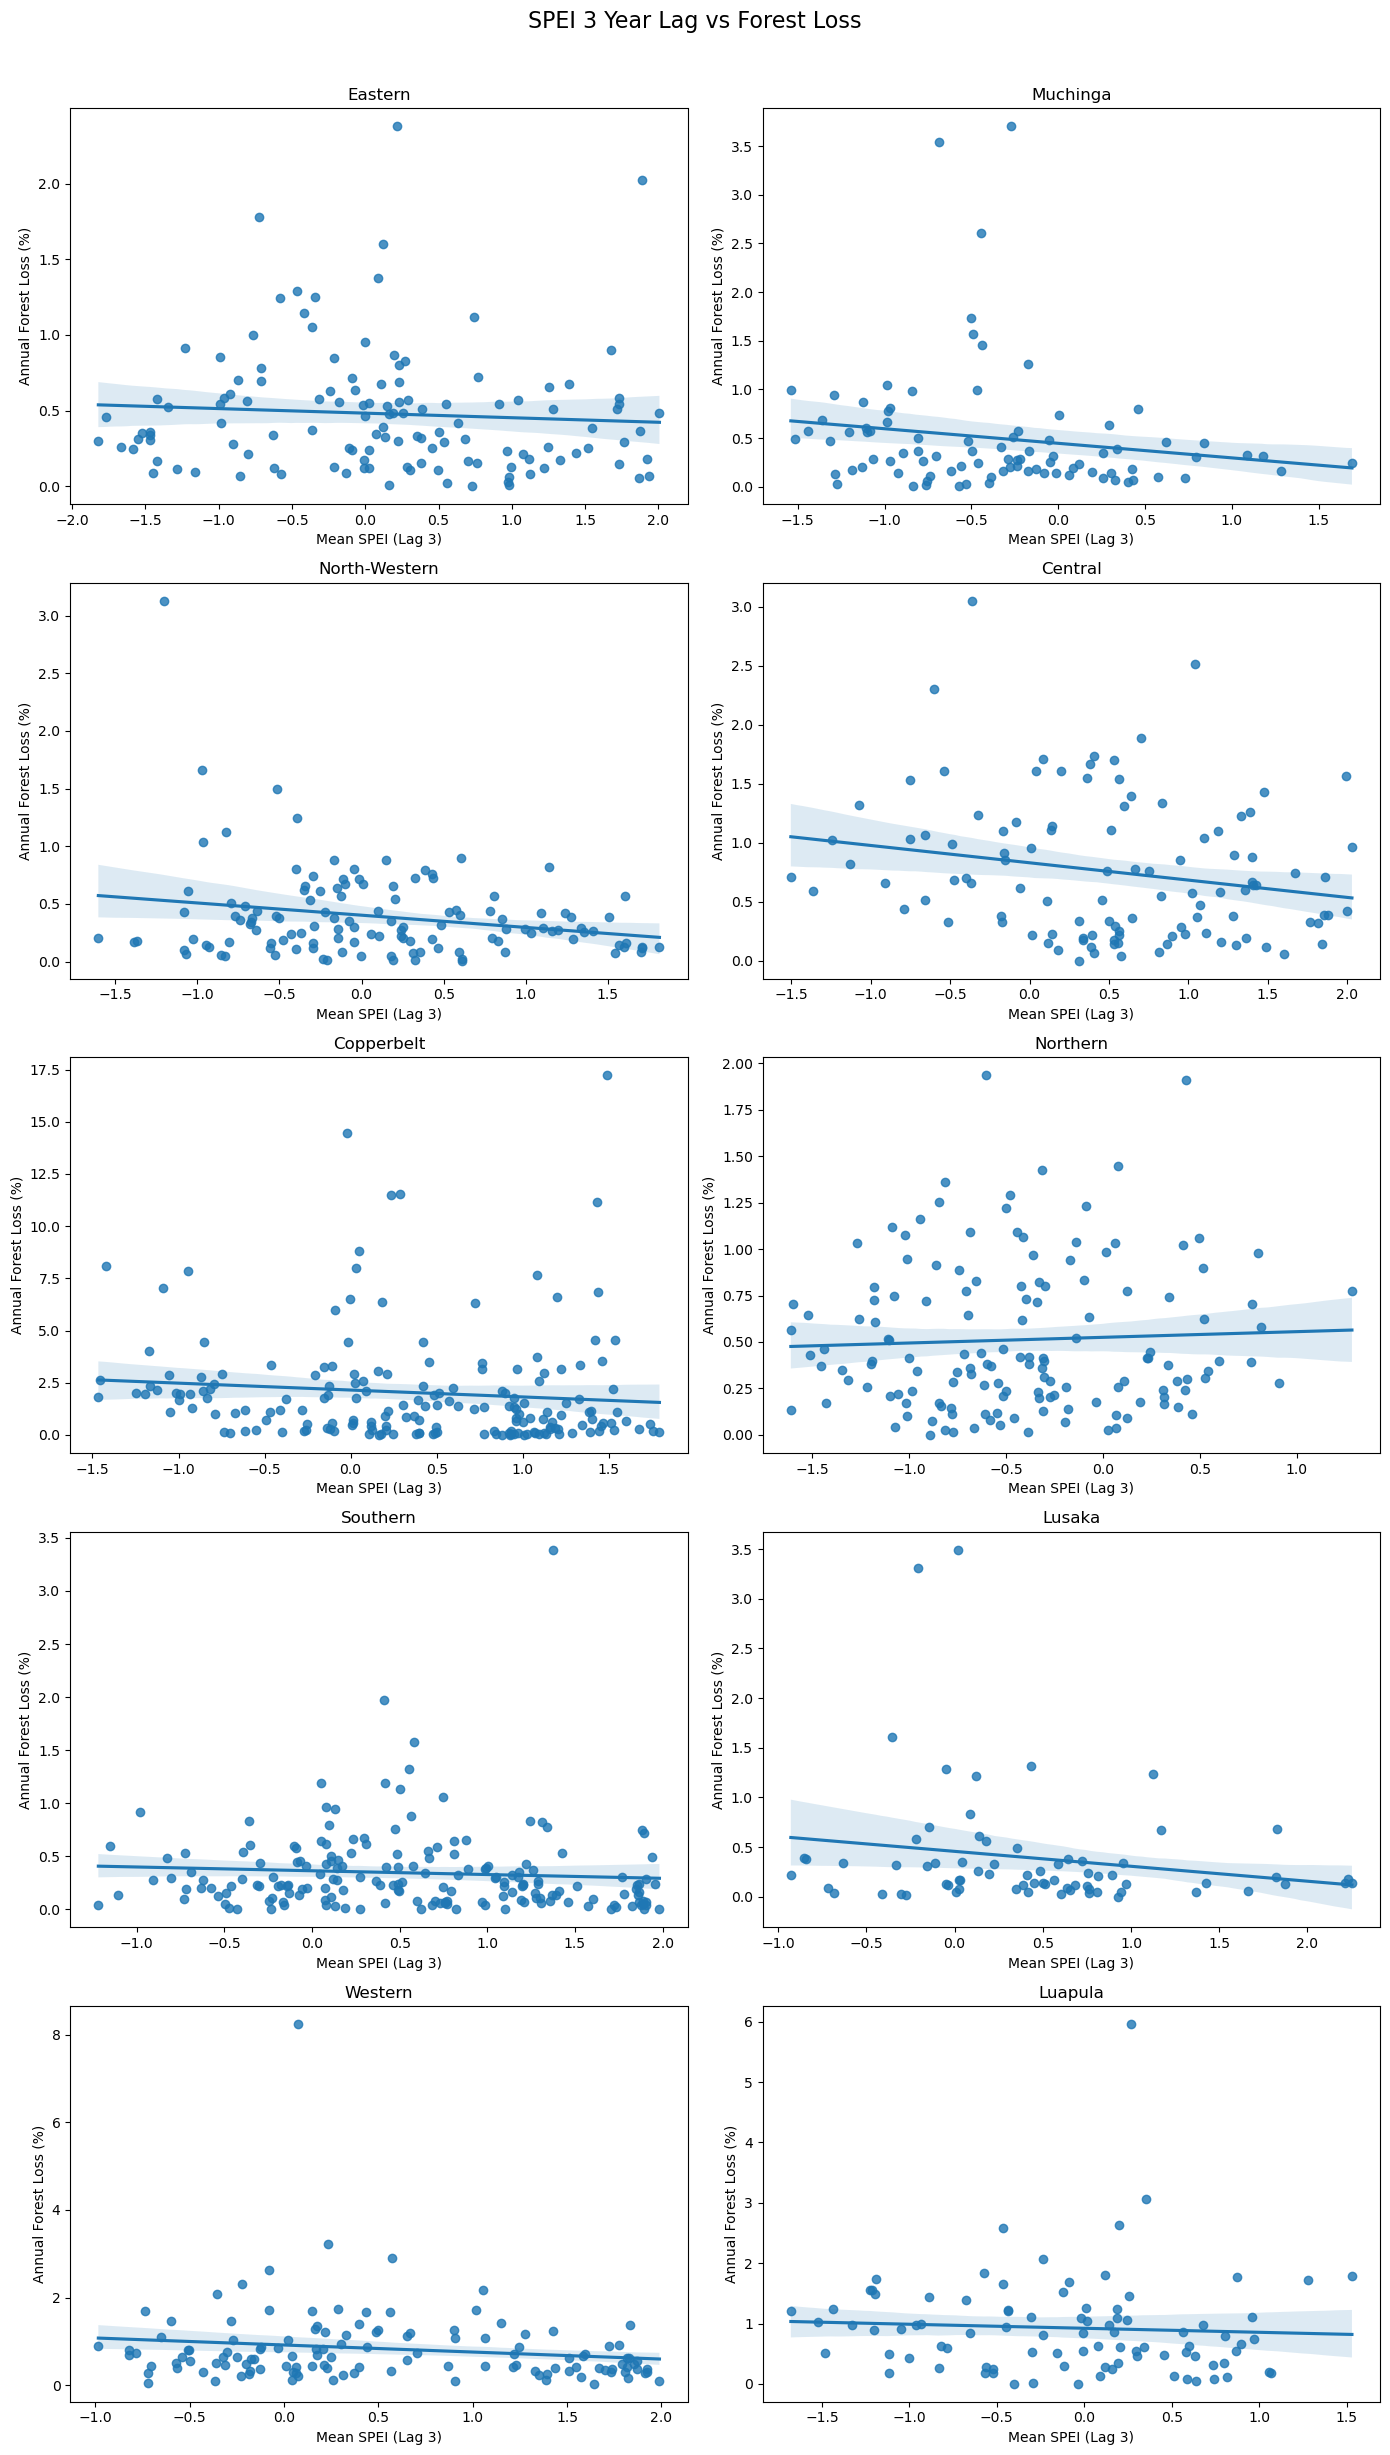

Lag 4: 1173 rows


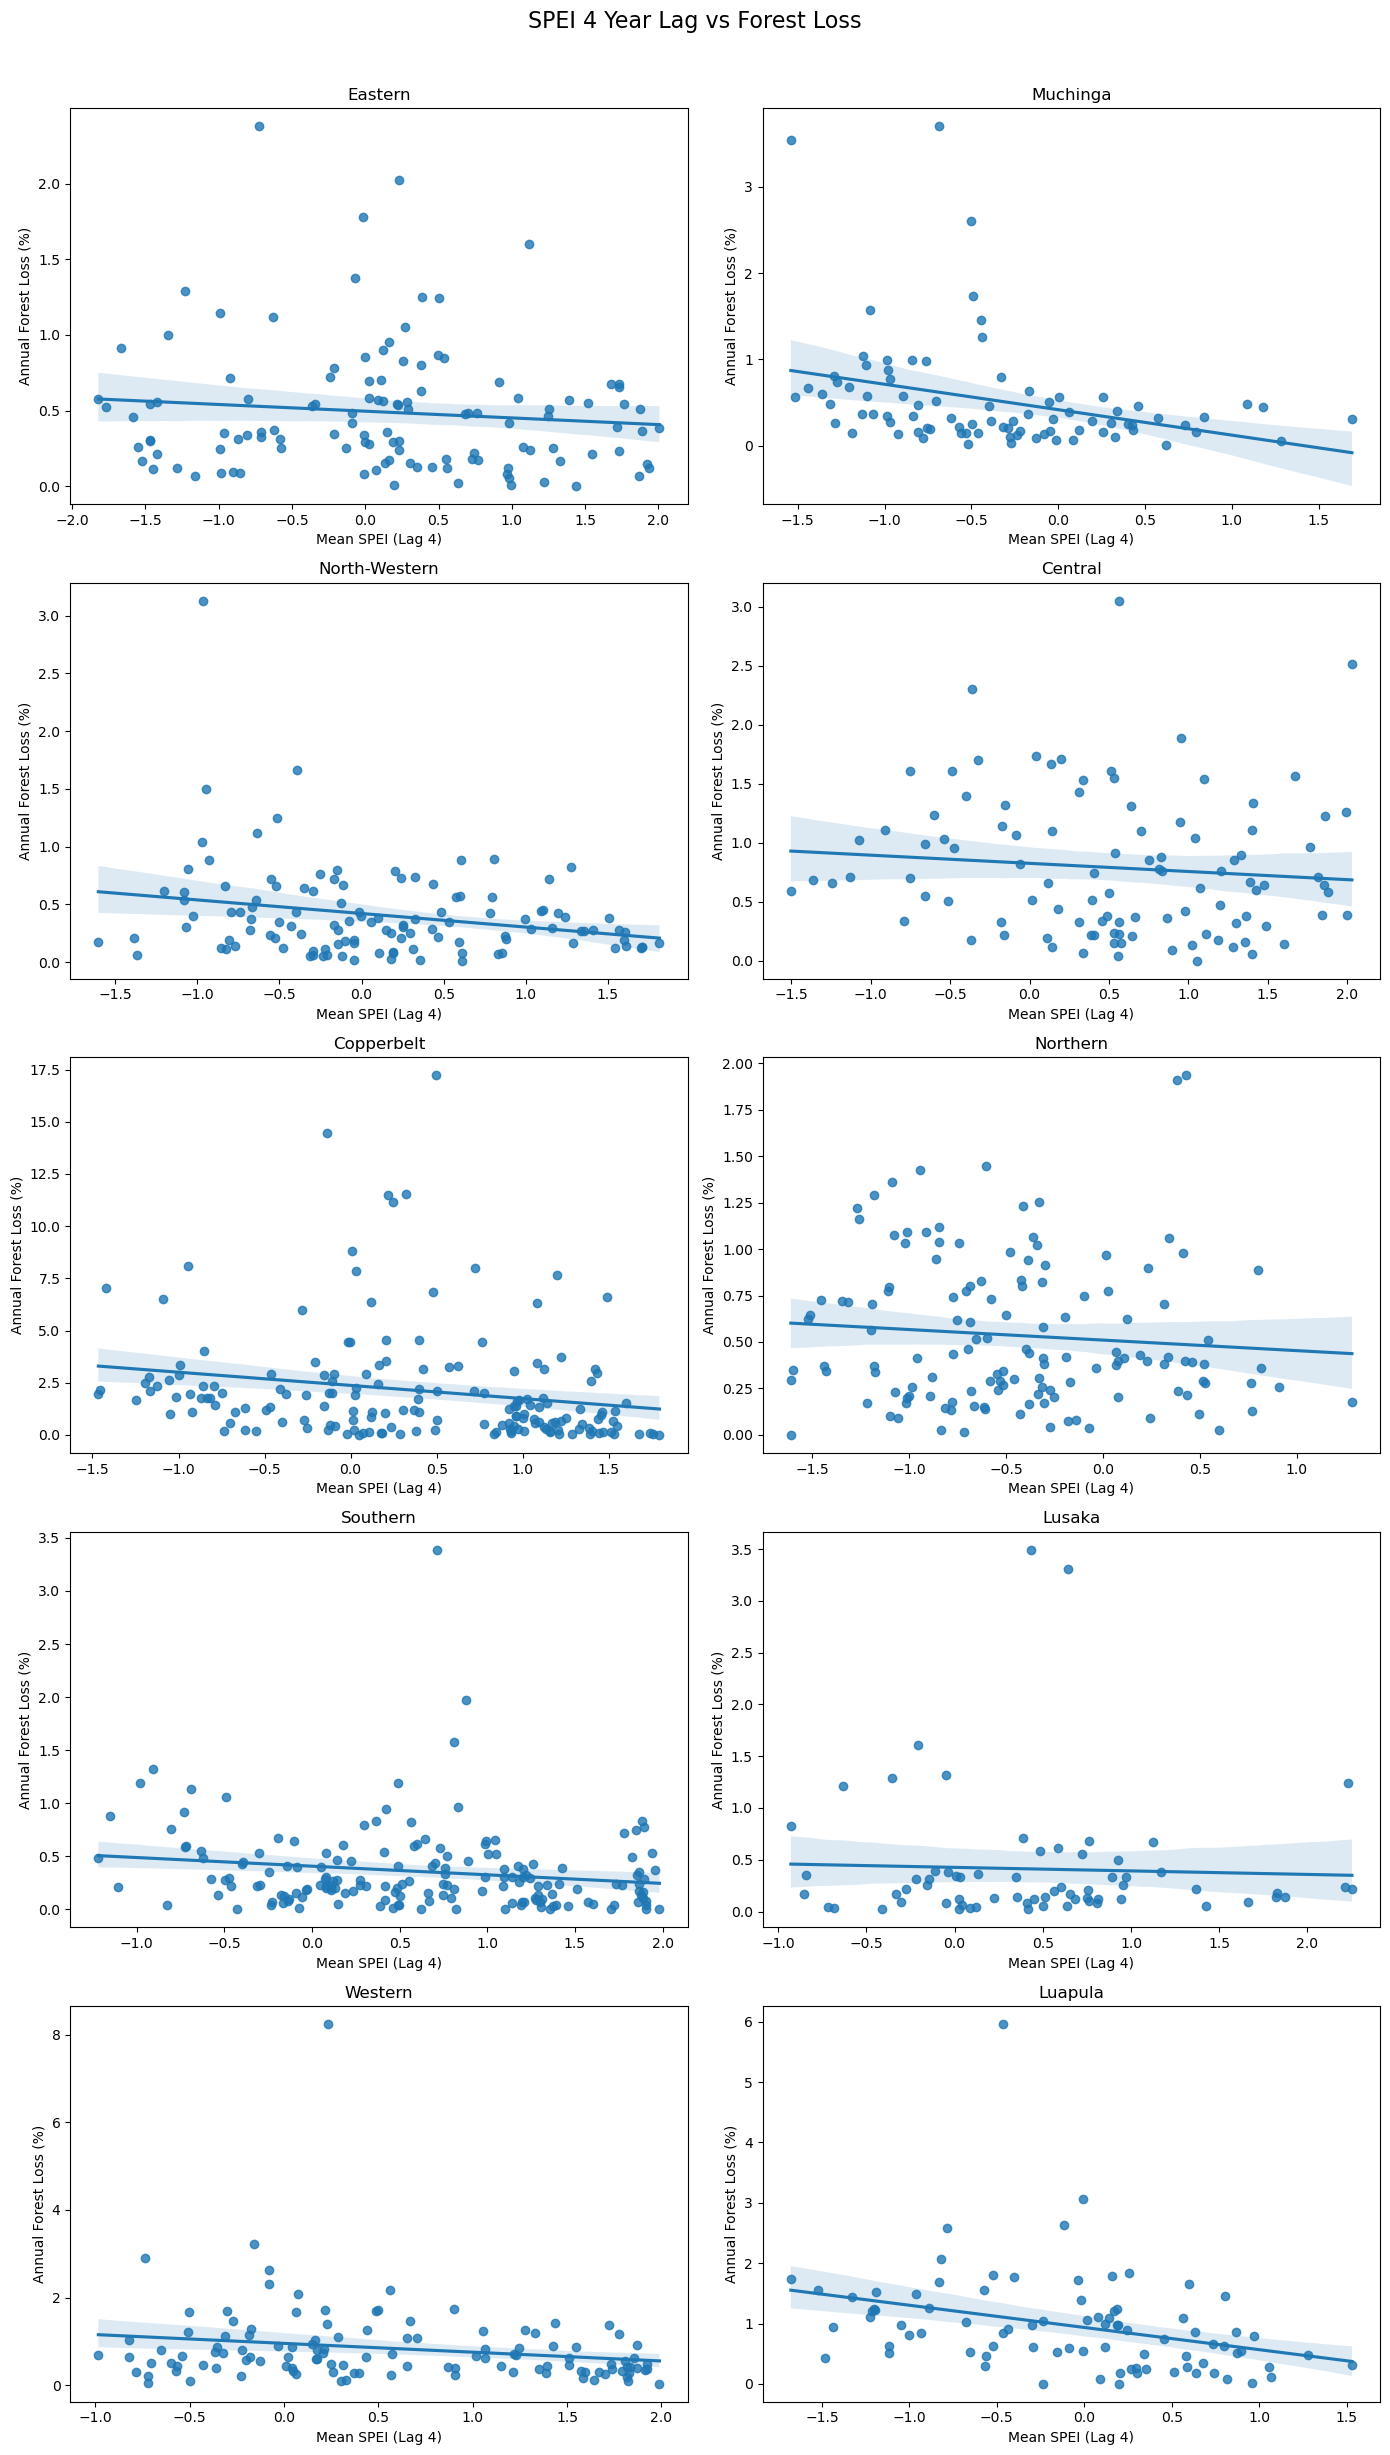

Lag 5: 1104 rows


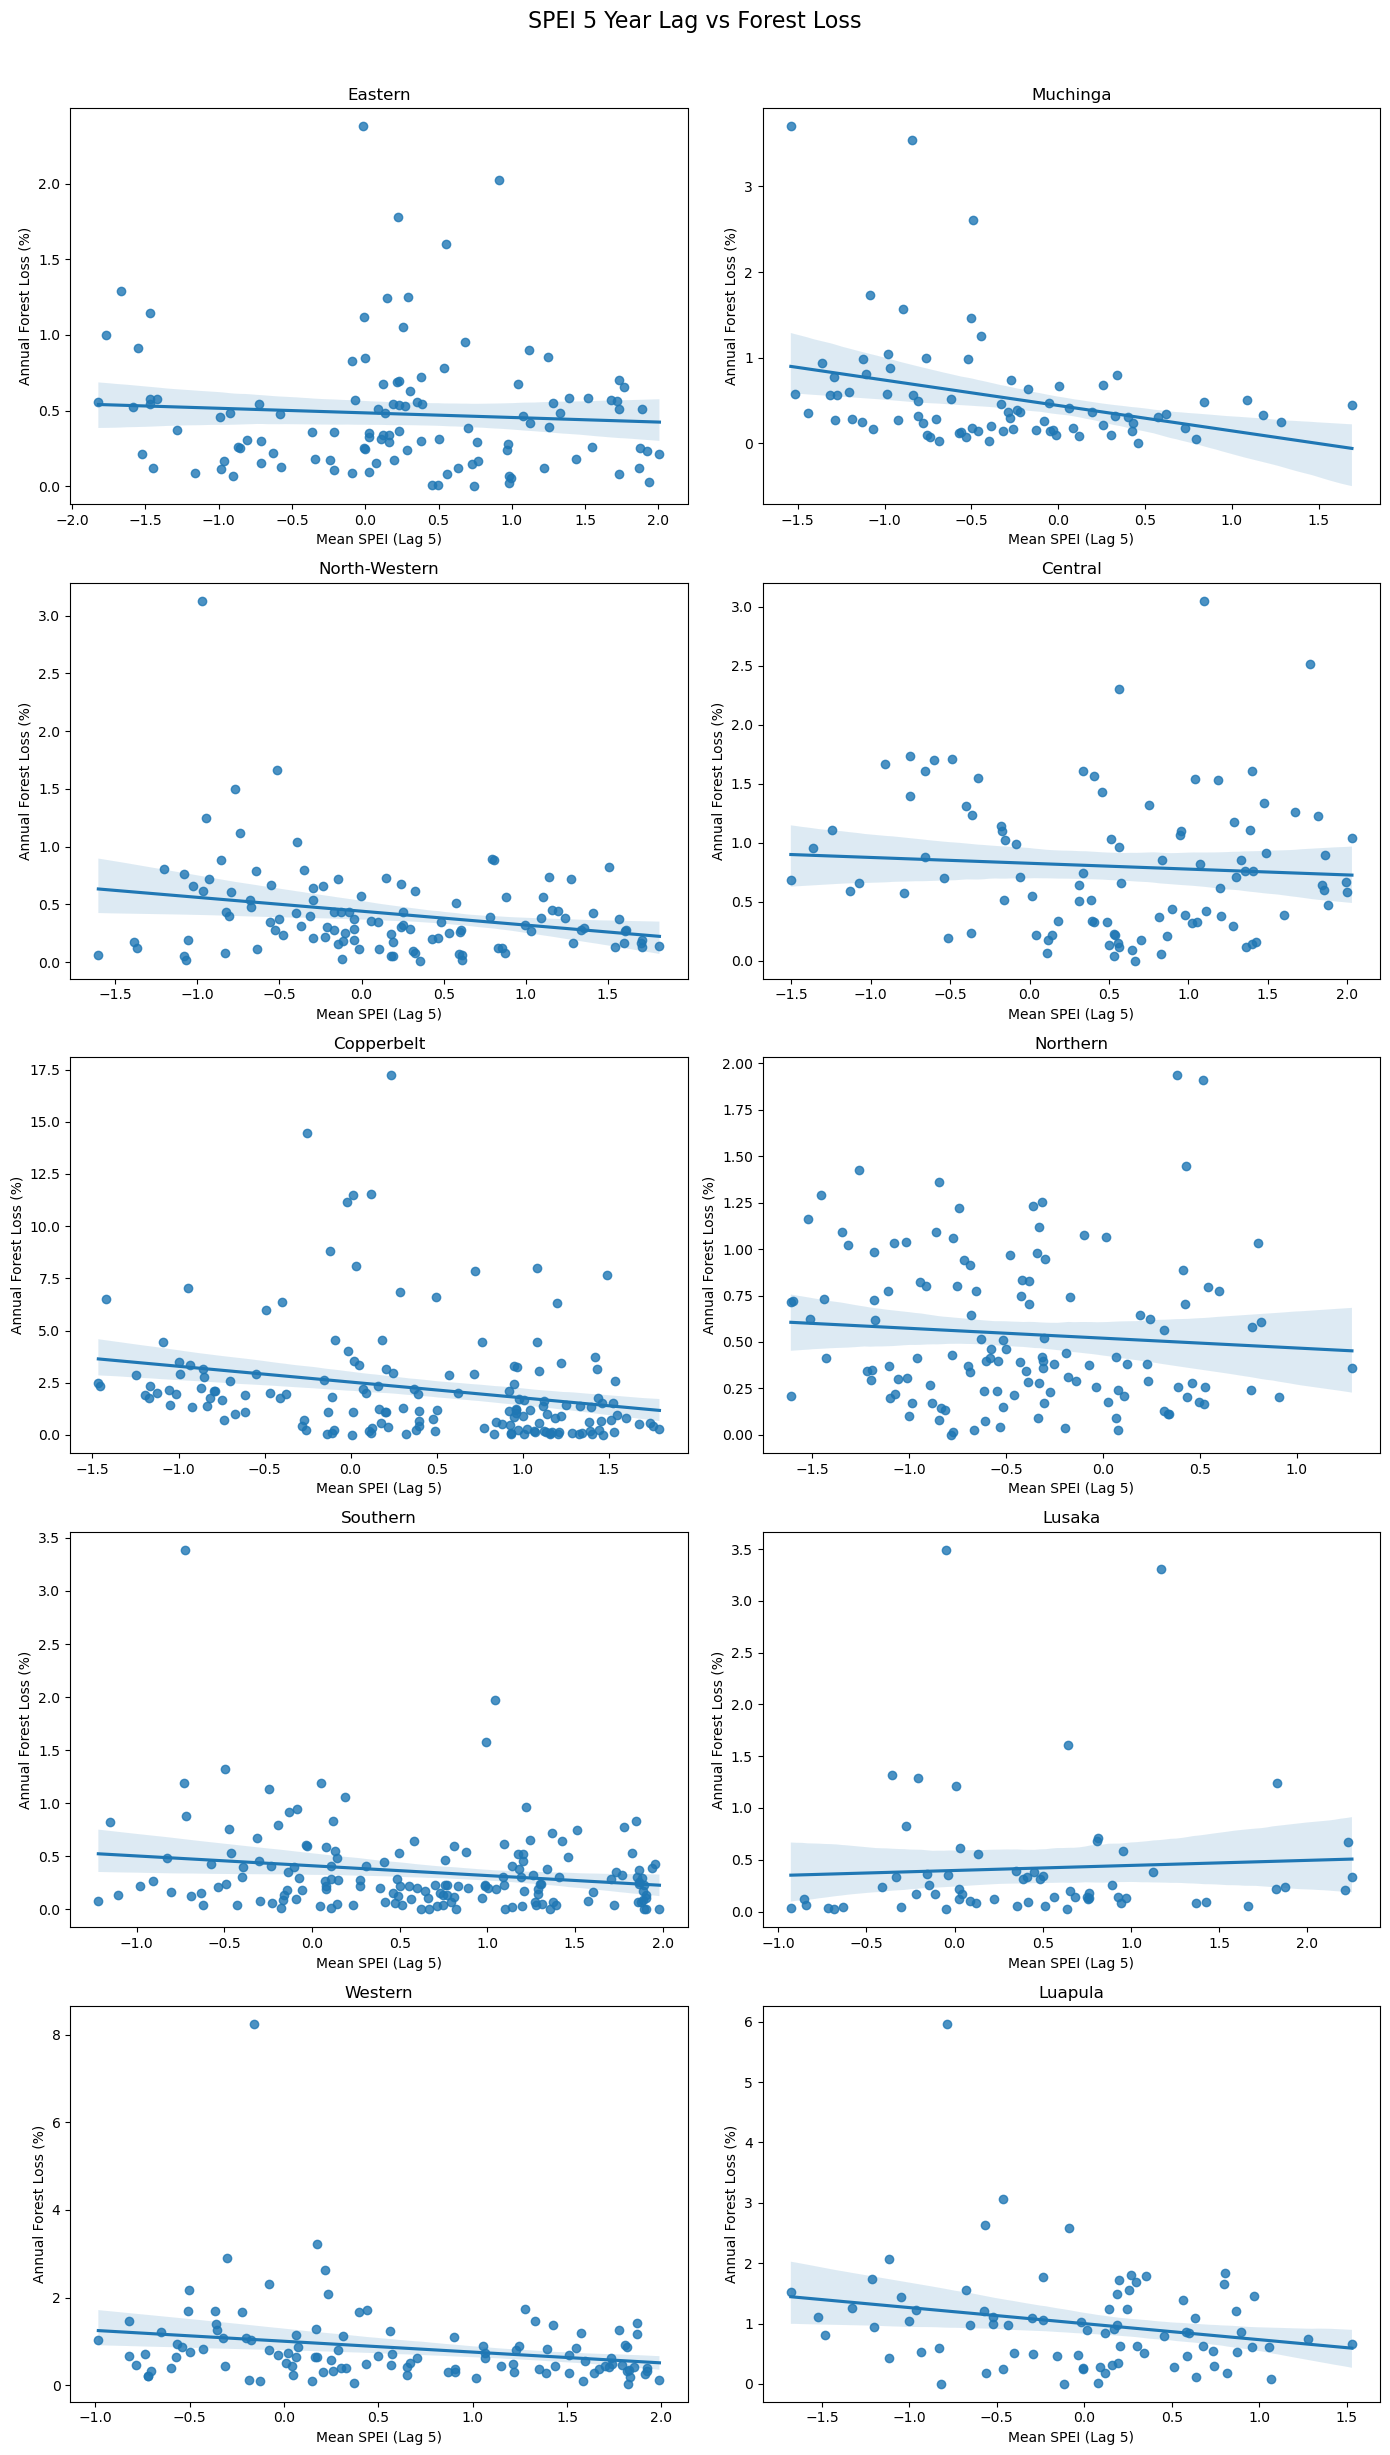

In [5]:
# generate lags
for lag in range(1, 6):
    merged_df[f'mean_spei_lag{lag}'] = merged_df.groupby('district')['mean_spei'].shift(lag)

# drop rows with missing values (just to be safe)
plot_df = merged_df.dropna(subset=['district', 'mean_spei', 'percent_loss_annual', 'province'])

# get unique provinces
provinces = plot_df['province'].unique()

# loop through each lag
for lag in range(1, 6):
    lag_col = f'mean_spei_lag{lag}'
    if lag_col not in plot_df.columns:
        print(f'Column {lag_col} not found. Skipping.')
        continue
    # drop rows with NA values for each lag
    lag_df = plot_df.dropna(subset=[lag_col]) 
    print(f'Lag {lag}: {len(lag_df)} rows')

    # set up plot grid
    cols = 2
    rows = (len(provinces) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
    axes = axes.flatten()

    # plot per province
    for i, province in enumerate(provinces):
        ax = axes[i]
        province_data = lag_df[lag_df['province'] == province]

        sns.regplot(
            data=province_data,
            x=lag_col,
            y='percent_loss_annual',
            ax=ax
        )

        ax.set_title(province)
        ax.set_xlabel(f'Mean SPEI (Lag {lag})')
        ax.set_ylabel('Annual Forest Loss (%)')
    

    # remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'SPEI {lag} Year Lag vs Forest Loss', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

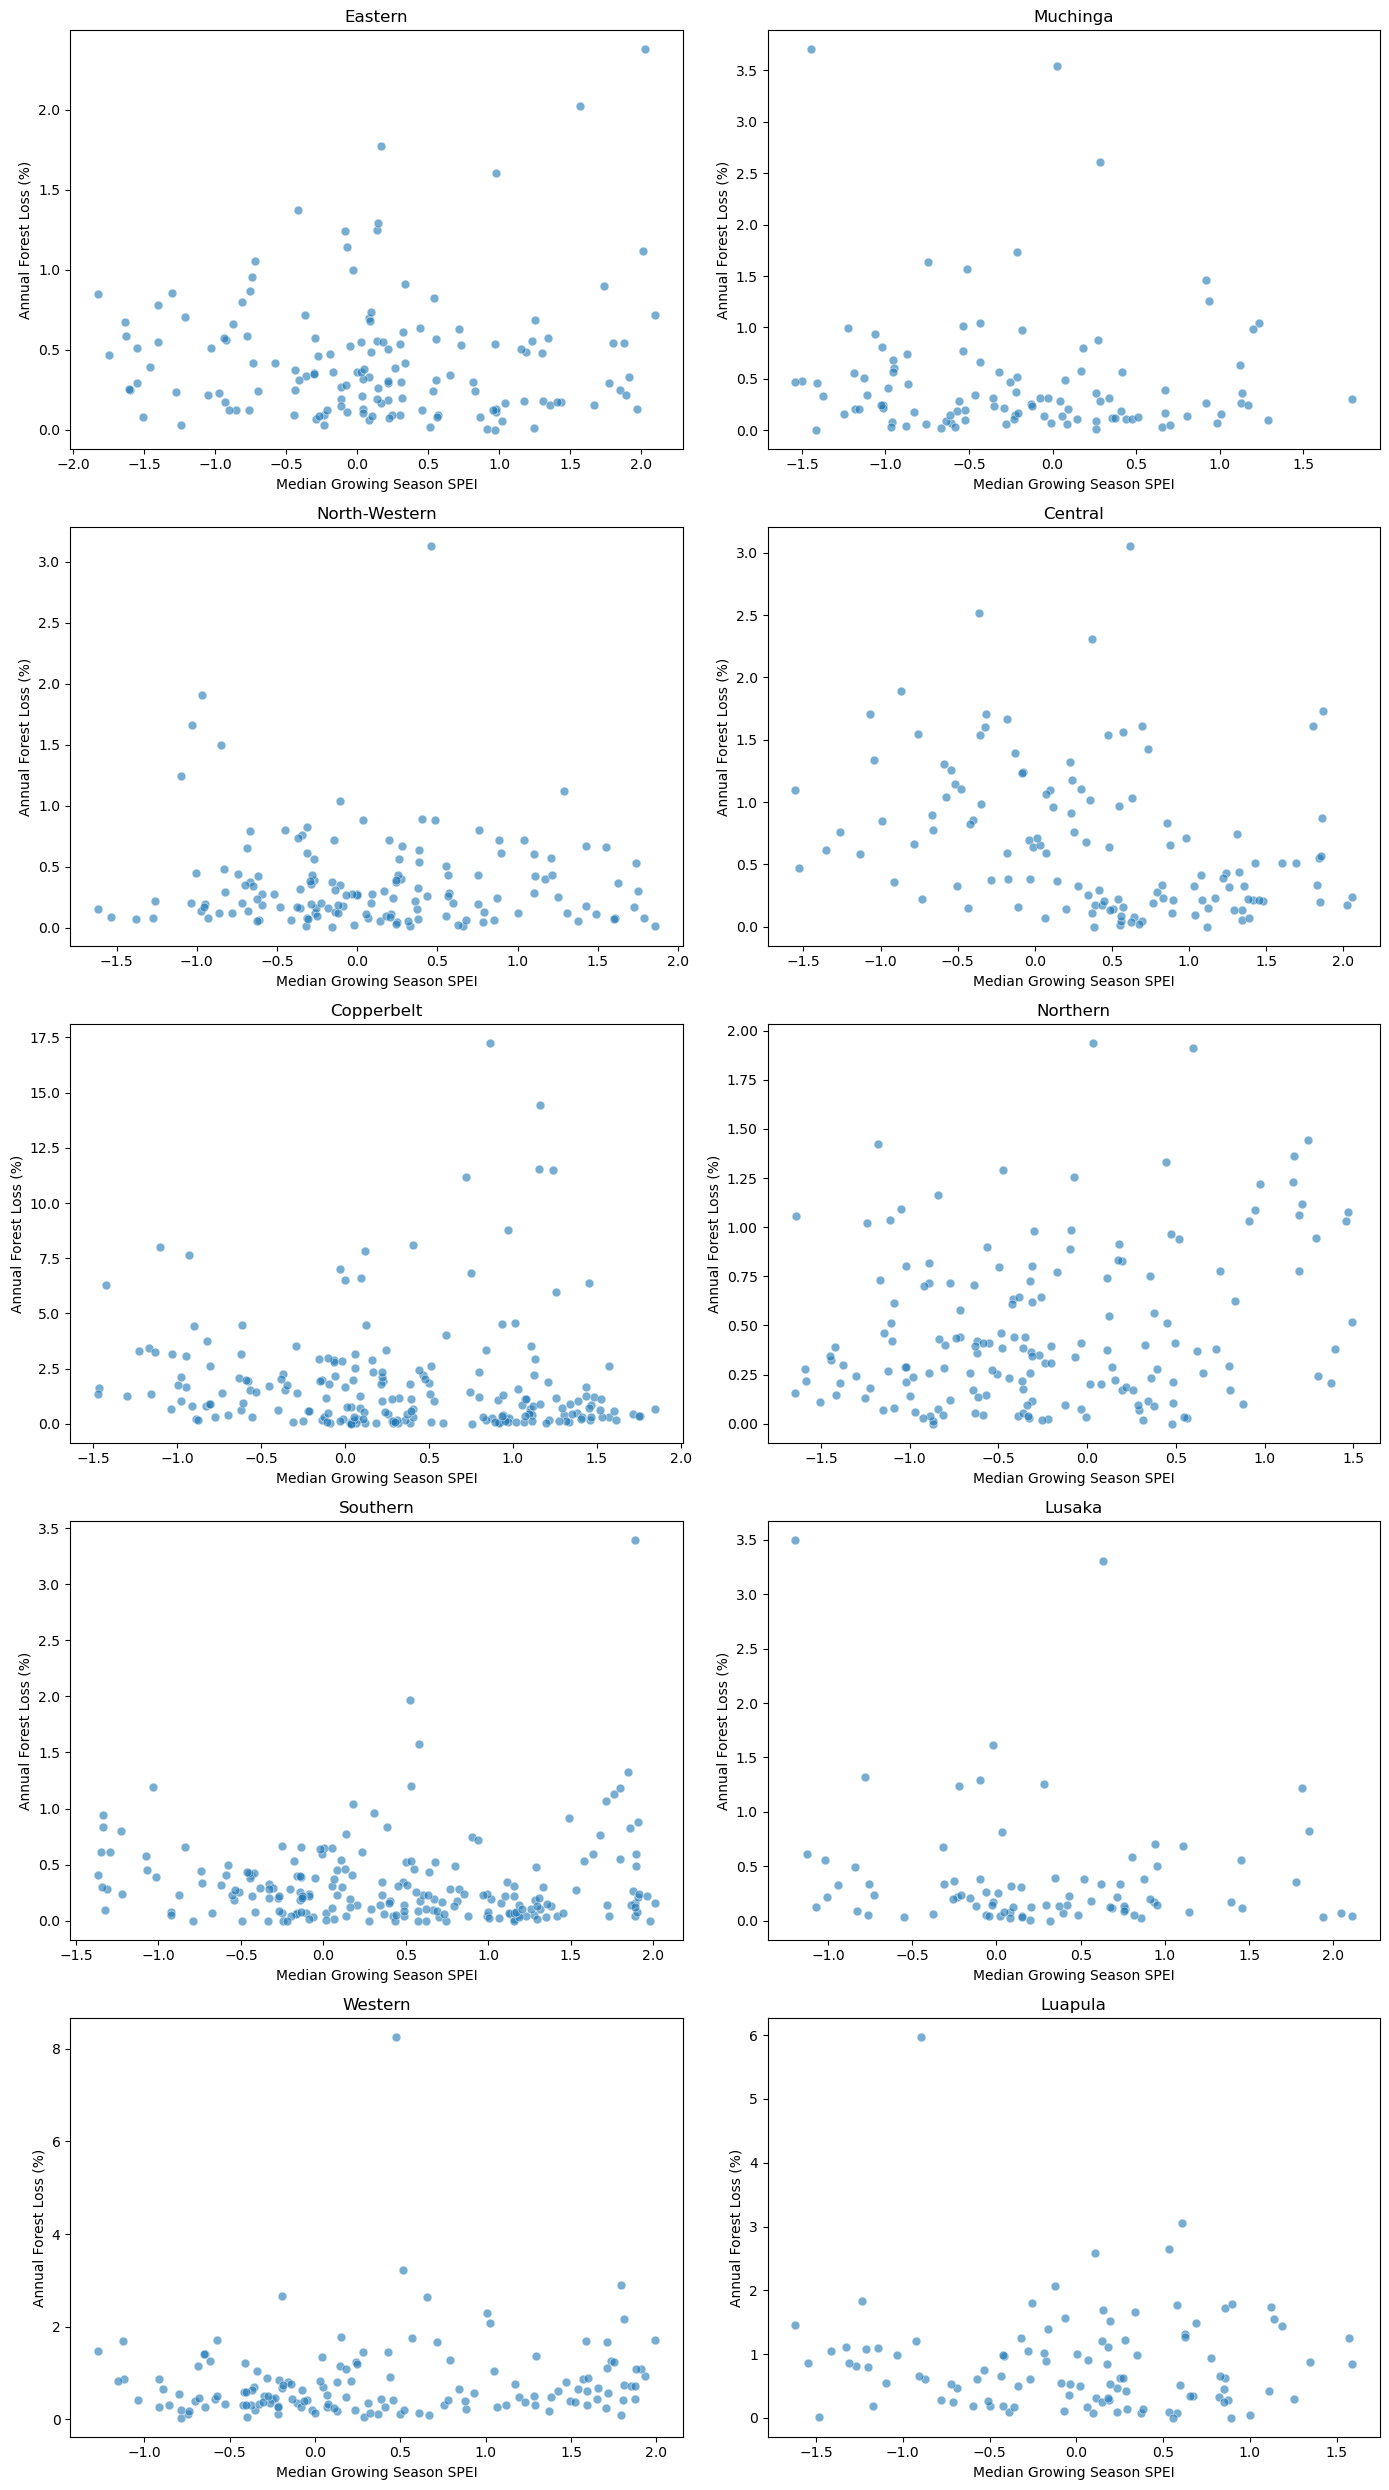

In [6]:
# drop rows with missing values (just to be safe)
plot_df = merged_df.dropna(subset=['district', 'median_spei', 'percent_loss_annual', 'province'])

# get unique provinces
provinces = plot_df['province'].unique()

# set up plot grid
cols = 2
rows = (len(provinces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
axes = axes.flatten()

# plot per province
for i, province in enumerate(provinces):
    ax = axes[i]
    province_data = plot_df[plot_df['province'] == province]

    sns.scatterplot(
        data=province_data,
        x='median_spei',
        y='percent_loss_annual',
        alpha=0.6,
        s=40,
        ax=ax
    )

    ax.set_title(province)
    ax.set_xlabel('Median Growing Season SPEI')
    ax.set_ylabel('Annual Forest Loss (%)')
    

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## Statistical analysis

In [7]:
# compute correlation per district without the deprecated behavior
correlation_df = (
    plot_df.groupby('district')[['mean_spei_lag1', 'percent_loss_annual']]
    .apply(lambda g: g['mean_spei_lag1'].corr(g['percent_loss_annual']))
    .reset_index(name='spei_lag1_vs_forest_loss_corr')
)

# sort correlation in descending order
correlation_df = correlation_df.sort_values(by='spei_lag1_vs_forest_loss_corr', ascending=False)

# Display the first few rows
print(correlation_df.head(10))

     district  spei_lag1_vs_forest_loss_corr
47   Mpulungu                       0.623123
40      Mbala                       0.596150
12      Isoka                       0.504332
29    Luangwa                       0.408251
51     Mungwi                       0.405103
1       Chama                       0.399007
54    Nakonde                       0.329470
8     Chipata                       0.329066
46  Mporokoso                       0.326991
60     Samfya                       0.317748


In [8]:
# compute correlation and p-value per district
def compute_corr_pval(group):
    group = group.replace([np.inf, -np.inf], np.nan).dropna(subset=['mean_spei_lag1', 'percent_loss_annual'])
    if len(group) < 3:  # not enough data
        return pd.Series({'correlation': None, 'p_value': None})
    r, p = pearsonr(group['mean_spei_lag1'], group['percent_loss_annual'])
    return pd.Series({'correlation': r, 'p_value': p})

# apply function to each district
correlation_df = (
    plot_df.groupby('district')[['mean_spei_lag1', 'percent_loss_annual']]
    .apply(compute_corr_pval)
    .reset_index()
)

# drop districts with NaNs 
correlation_df = correlation_df.dropna()

# sort by correlation in descending order
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

# show only significant results (p < 0.05)
significant_results = correlation_df[correlation_df['p_value'] < 0.05]

print(significant_results)

    district  correlation   p_value
47  Mpulungu     0.623123  0.003335
40     Mbala     0.596150  0.005535
12     Isoka     0.504332  0.023355
50    Mumbwa    -0.477880  0.033082


### Longer lags

In [9]:
def compute_lag_corrs(group):
    results = {}
    for lag in range(1, 6):
        col = f'mean_spei_lag{lag}'
        y_col = 'percent_loss_annual'
        if col in group:
            # drop NaNs
            valid = group[[col, y_col]].dropna()
            if len(valid) >= 3:
                slope, intercept, r_value, p_value, std_err = linregress(valid[col], valid[y_col])
                results[f'corr_lag{lag}'] = r_value
                results[f'pval_lag{lag}'] = p_value
                results[f'slope_lag{lag}'] = slope
                results[f'r2_lag{lag}'] = r_value ** 2
            else:
                results[f'corr_lag{lag}'] = None
                results[f'pval_lag{lag}'] = None
                results[f'slope_lag{lag}'] = None
                results[f'r2_lag{lag}'] = None

        else:
            results[f'corr_lag{lag}'] = None
            results[f'pval_lag{lag}'] = None
            results[f'slope_lag{lag}'] = None
            results[f'r2_lag{lag}'] = None
            
    return pd.Series(results)

In [10]:
plot_df['mean_spei_lag1'] = plot_df.groupby('district')['mean_spei'].shift(1)
plot_df['mean_spei_lag2'] = plot_df.groupby('district')['mean_spei'].shift(2)
plot_df['mean_spei_lag3'] = plot_df.groupby('district')['mean_spei'].shift(3)
plot_df['mean_spei_lag4'] = plot_df.groupby('district')['mean_spei'].shift(4)
plot_df['mean_spei_lag5'] = plot_df.groupby('district')['mean_spei'].shift(5)

multi_lag_corrs = (
    plot_df.groupby('district')[['mean_spei_lag1', 'mean_spei_lag2', 'mean_spei_lag3', 'mean_spei_lag4', 'mean_spei_lag5', 'percent_loss_annual']]
    .apply(compute_lag_corrs)
    .reset_index()
)

# Filter and print significant correlations for each lag
for lag in range(1, 6):
    corr_col = f'corr_lag{lag}'
    pval_col = f'pval_lag{lag}'
    slope_col = f'slope_lag{lag}'
    r2_col = f'r2_lag{lag}'
    
    significant = multi_lag_corrs[multi_lag_corrs[pval_col] < 0.05][['district', corr_col, pval_col, slope_col, r2_col]]
    
    print(f'\nSignificant correlations for Lag {lag} (p < 0.05):')
    print(significant.sort_values(by=corr_col, ascending=False).to_string(index=False))


Significant correlations for Lag 1 (p < 0.05):
district  corr_lag1  pval_lag1  slope_lag1  r2_lag1
Mpulungu   0.623123   0.003335    0.137493 0.388282
   Mbala   0.596150   0.005535    0.312775 0.355395
   Isoka   0.504332   0.023355    0.121074 0.254351
  Mumbwa  -0.477880   0.033082   -0.304023 0.228370

Significant correlations for Lag 2 (p < 0.05):
district  corr_lag2  pval_lag2  slope_lag2  r2_lag2
Mpulungu   0.564731   0.011763    0.153512 0.318922
 Serenje  -0.465627   0.044524   -0.128188 0.216809
  Mwense  -0.504103   0.027752   -0.410085 0.254120
 Chavuma  -0.517097   0.023378   -0.529901 0.267389
   Mansa  -0.536065   0.017988   -0.509601 0.287366

Significant correlations for Lag 3 (p < 0.05):
district  corr_lag3  pval_lag3  slope_lag3  r2_lag3
 Serenje  -0.508148   0.031310   -0.135842 0.258214
 Chavuma  -0.521907   0.026310   -0.521685 0.272387
Chingola  -0.525405   0.025144   -0.493602 0.276050

Significant correlations for Lag 4 (p < 0.05):
     district  corr_lag4  pv

In [12]:
df = plot_df.copy()

# compute number of significant correlations (p < 0.05)
def count_significant(df):
    sig_count = 0
    for district, group in df.groupby('district'):
        for lag in range(1, 6):
            col = f'mean_spei_lag{lag}'
            if col in group:
                valid = group[[col, 'percent_loss_annual']].dropna()
                if len(valid) >= 3:
                    slope, intercept, r_value, p_value, std_err = linregress(valid[col], valid['percent_loss_annual'])
                    if p_value < 0.05:
                        sig_count += 1
    return sig_count

# get count of significant results
actual_count = count_significant(df)

# run permutations
n_permutations = 1000
perm_counts = []

for _ in range(n_permutations):
    shuffled_df = df.copy()
    shuffled_df['shuffled_loss'] = (
        shuffled_df.groupby('district')['percent_loss_annual']
        .transform(lambda x: np.random.permutation(x.values))
    )
    count = 0
    for district, group in shuffled_df.groupby('district'):
        for lag in range(1, 6):
            col = f'mean_spei_lag{lag}'
            if col in group:
                valid = group[[col, 'shuffled_loss']].dropna()
                if len(valid) >= 3:
                    slope, intercept, r_value, p_value, std_err = linregress(valid[col], valid['shuffled_loss'])
                    if p_value < 0.05:
                        count += 1
    perm_counts.append(count)

# compute empirical p-value
empirical_p = np.mean(np.array(perm_counts) >= actual_count)

print(f'Actual significant count: {actual_count}')
print(f'Mean permuted count: {np.mean(perm_counts):.2f}')
print(f'Empirical p-value: {empirical_p:.4f}')

Actual significant count: 27
Mean permuted count: 16.49
Empirical p-value: 0.0230


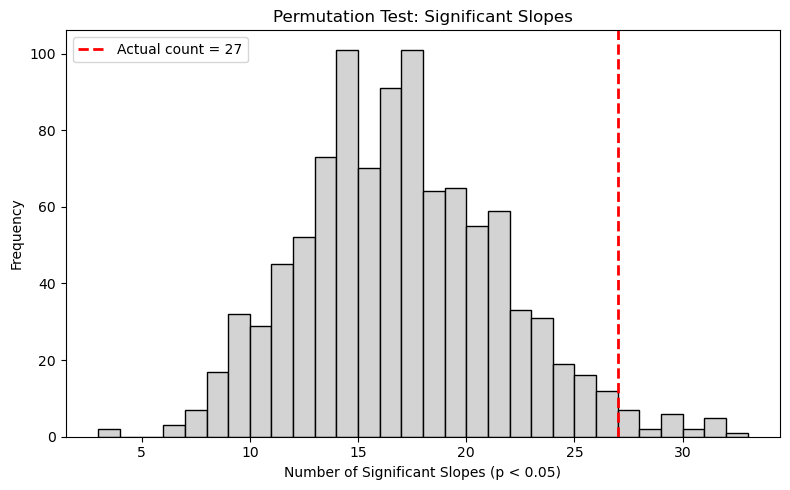

In [16]:
plt.figure(figsize=(8, 5))
plt.hist(perm_counts, bins=30, color='lightgray', edgecolor='black')
plt.axvline(actual_count, color='red', linestyle='dashed', linewidth=2, label=f'Actual count = {actual_count}')
plt.title('Permutation Test: Significant Slopes')
plt.xlabel('Number of Significant Slopes (p < 0.05)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
plot_df['mean_spei_lag1'] = plot_df.groupby('district')['mean_spei'].shift(1)
plot_df['mean_spei_lag2'] = plot_df.groupby('district')['mean_spei'].shift(2)
plot_df['mean_spei_lag3'] = plot_df.groupby('district')['mean_spei'].shift(3)
plot_df['mean_spei_lag4'] = plot_df.groupby('district')['mean_spei'].shift(4)
plot_df['mean_spei_lag5'] = plot_df.groupby('district')['mean_spei'].shift(5)

multi_lag_corrs = (
    plot_df.groupby('district')[['mean_spei_lag1', 'mean_spei_lag2', 'mean_spei_lag3', 'mean_spei_lag4', 'mean_spei_lag5', 'percent_loss_annual']]
    .apply(compute_lag_corrs)
    .reset_index()
)

# Filter and print significant correlations for each lag
for lag in [1, 2, 3, 4, 5]:
    corr_col = f'corr_lag{lag}'
    pval_col = f'pval_lag{lag}'
    
    significant = multi_lag_corrs[multi_lag_corrs[pval_col] < 0.05][['district', corr_col, pval_col]]
    
    print(f"\nSignificant correlations for Lag {lag} (p < 0.05):")
    print(significant.sort_values(by=corr_col, ascending=False).to_string(index=False))


Significant correlations for Lag 1 (p < 0.05):
district  corr_lag1  pval_lag1
Mpulungu   0.623123   0.003335
   Mbala   0.596150   0.005535
   Isoka   0.504332   0.023355
  Mumbwa  -0.477880   0.033082

Significant correlations for Lag 2 (p < 0.05):
district  corr_lag2  pval_lag2
Mpulungu   0.564731   0.011763
 Serenje  -0.465627   0.044524
  Mwense  -0.504103   0.027752
 Chavuma  -0.517097   0.023378
   Mansa  -0.536065   0.017988

Significant correlations for Lag 3 (p < 0.05):
district  corr_lag3  pval_lag3
 Serenje  -0.508148   0.031310
 Chavuma  -0.521907   0.026310
Chingola  -0.525405   0.025144

Significant correlations for Lag 4 (p < 0.05):
     district  corr_lag4  pval_lag4
        Mansa  -0.500715   0.040635
Chililabombwe  -0.522337   0.031478
       Kalomo  -0.523223   0.031140
       Mwense  -0.530426   0.028494
      Luwingu  -0.545175   0.023619
     Chingola  -0.652426   0.004530
     Chinsali  -0.656890   0.004173

Significant correlations for Lag 5 (p < 0.05):
     di

In [12]:
plot_df.head()

,Unnamed: 0.1,Unnamed: 0,district,year,mean_spei,median_spei,n_months,province,province_avg_start_date,province_avg_end_date,forest_cover_ha,loss_m2,percent_loss_annual,mean_spei_lag1,mean_spei_lag2,mean_spei_lag3,mean_spei_lag4,mean_spei_lag5
0,1,1,Chadiza,2001,0.353488,0.303945,6,Eastern,November 26,May 04,57181.013721,5.136993e+05,0.089757,NaN,NaN,NaN,NaN,NaN
1,2,2,Chadiza,2002,0.281255,0.244052,6,Eastern,November 26,May 04,57127.207503,5.380622e+05,0.094098,0.353488,NaN,NaN,NaN,NaN
2,3,3,Chadiza,2003,0.227219,0.217295,5,Eastern,November 26,May 04,56960.977318,1.662302e+06,0.290983,0.281255,0.353488,NaN,NaN,NaN
3,4,4,Chadiza,2004,0.025194,0.084612,6,Eastern,November 26,May 04,56773.795452,1.871819e+06,0.328614,0.227219,0.281255,0.353488,NaN,NaN
4,5,5,Chadiza,2005,-0.712003,-0.763748,5,Eastern,November 26,May 04,56703.324923,7.047053e+05,0.124125,0.025194,0.227219,0.281255,0.353488,NaN


## Z scores

In [9]:
plot_df['z_score_loss'] = (
    plot_df.groupby('district')['percent_loss_annual']
           .transform(lambda x: (x - x.mean()) / x.std())
)

plot_df.tail()

,Unnamed: 0.1,Unnamed: 0,district,year,mean_spei,median_spei,n_months,province,province_avg_start_date,province_avg_end_date,forest_cover_ha,loss_m2,percent_loss_annual,mean_spei_lag1,mean_spei_lag2,mean_spei_lag3,mean_spei_lag4,mean_spei_lag5,z_score_loss
1444,2503,2503,Zambezi,2017,-0.151061,-0.145715,6,North-Western,November 04,May 06,598630.212278,4.351229e+07,0.721619,-0.348447,-0.294945,0.325636,1.142590,1.276232,0.985589
1445,2504,2504,Zambezi,2018,-0.397999,-0.367019,6,North-Western,November 04,May 06,594211.255070,4.418957e+07,0.738178,-0.151061,-0.348447,-0.294945,0.325636,1.142590,1.044674
1446,2505,2505,Zambezi,2019,-0.205716,-0.310716,6,North-Western,November 04,May 06,590540.125435,3.671130e+07,0.617816,-0.397999,-0.151061,-0.348447,-0.294945,0.325636,0.615204
1447,2506,2506,Zambezi,2020,0.248603,0.383940,7,North-Western,November 04,May 06,586751.028881,3.789097e+07,0.641632,-0.205716,-0.397999,-0.151061,-0.348447,-0.294945,0.700185
1448,2507,2507,Zambezi,2021,-0.362755,-0.447916,5,North-Western,November 04,May 06,582053.919994,4.697109e+07,0.800528,0.248603,-0.205716,-0.397999,-0.151061,-0.348447,1.267149


## Heatmap

In [20]:
data = [
    # 1 year lag
    {'district': 'Mpulungu', 'lag': 1, 'correlation': 0.623123},
    {'district': 'Mbala', 'lag': 1, 'correlation': 0.596150},
    {'district': 'Isoka', 'lag': 1, 'correlation': 0.504332},
    {'district': 'Mumbwa', 'lag': 1, 'correlation': -0.477880},
    # 2 year lag
    {'district': 'Mpulungu', 'lag': 2, 'correlation': 0.564731},
    {'district': 'Serenje', 'lag': 2, 'correlation': -0.465627},
    {'district': 'Mwense', 'lag': 2, 'correlation': -0.504103},
    {'district': 'Chavuma', 'lag': 2, 'correlation': -0.517097},
    {'district': 'Mansa', 'lag': 2, 'correlation': -0.536065},
    # 3 year lag
    {'district': 'Serenje', 'lag': 3, 'correlation': -0.508148},
    {'district': 'Chavuma', 'lag': 3, 'correlation': -0.521907},
    {'district': 'Chingola', 'lag': 3, 'correlation': -0.525405},
    # 4 year lag
    {'district': 'Mansa', 'lag': 4, 'correlation': -0.500715},
    {'district': 'Chililabombwe', 'lag': 4, 'correlation': -0.522337},
    {'district': 'Kalomo', 'lag': 4, 'correlation': -0.523223},
    {'district': 'Mwense', 'lag': 4, 'correlation': -0.530426},
    {'district': 'Luwingu', 'lag': 4, 'correlation': -0.545175},
    {'district': 'Chingola', 'lag': 4, 'correlation': -0.652426},
    {'district': 'Chinsali', 'lag': 4, 'correlation': -0.656890},
    # 5 year lag
    {'district': 'Lufwanyama', 'lag': 5, 'correlation': -0.508368},
    {'district': 'Senanga', 'lag': 5, 'correlation': -0.526704},
    {'district': 'Kasama', 'lag': 5, 'correlation': -0.557806},
    {'district': 'Chingola', 'lag': 5, 'correlation': -0.577668},
    {'district': 'Chinsali', 'lag': 5, 'correlation': -0.606120},
    {'district': 'Namwala', 'lag': 5, 'correlation': -0.64915},
    {'district': 'Chililabombwe', 'lag': 5, 'correlation': -0.669166},
    {'district': 'Kalomo', 'lag': 5, 'correlation': -0.672218}

]

sig_df = pd.DataFrame(data)

sig_df.head()

,district,lag,correlation
0,Mpulungu,1,0.623123
1,Mbala,1,0.596150
2,Isoka,1,0.504332
3,Mumbwa,1,-0.477880
4,Mpulungu,2,0.564731


In [1]:
# pivot data into matrix form
heatmap_data = sig_df.pivot(index='district', columns='lag', values='correlation')

# plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='coolwarm_r',
    center=0,
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Significant Correlations Between SPEI and Forest Loss by District')
plt.xlabel('Lag (years)')
plt.ylabel('District')
plt.tight_layout()
plt.show()
    

NameError: name 'sig_df' is not defined

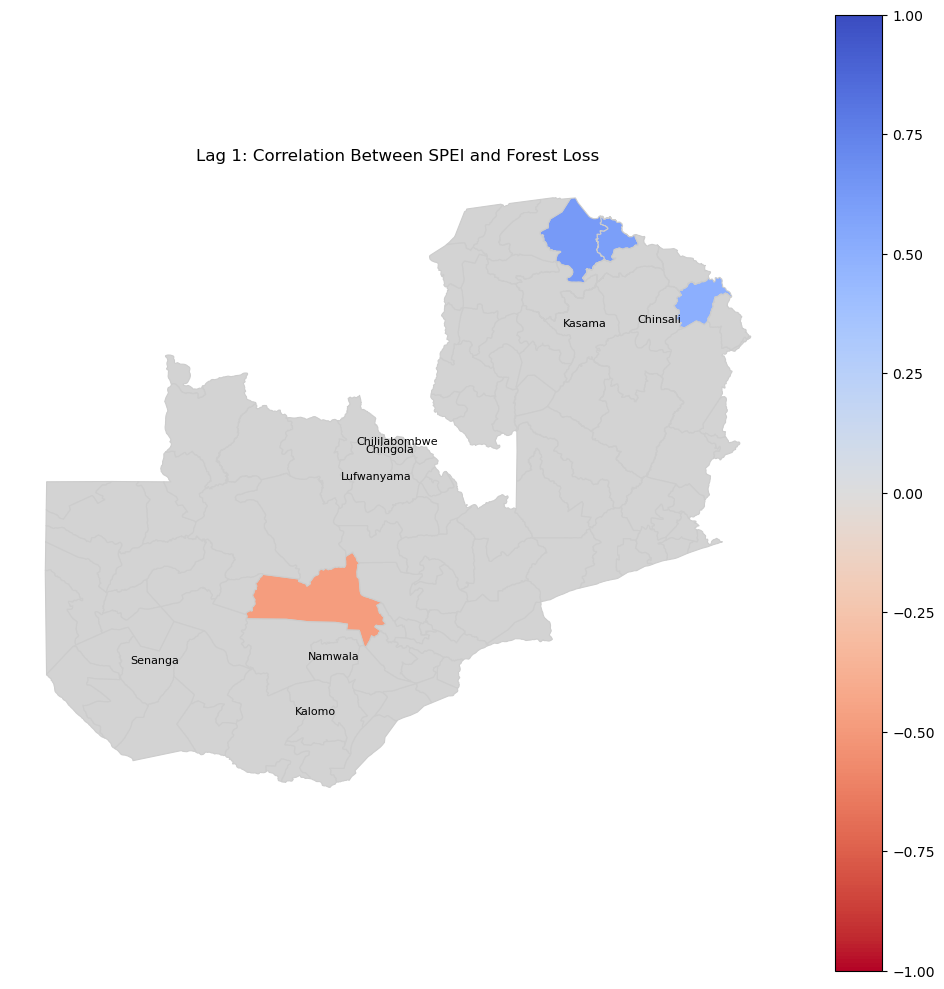

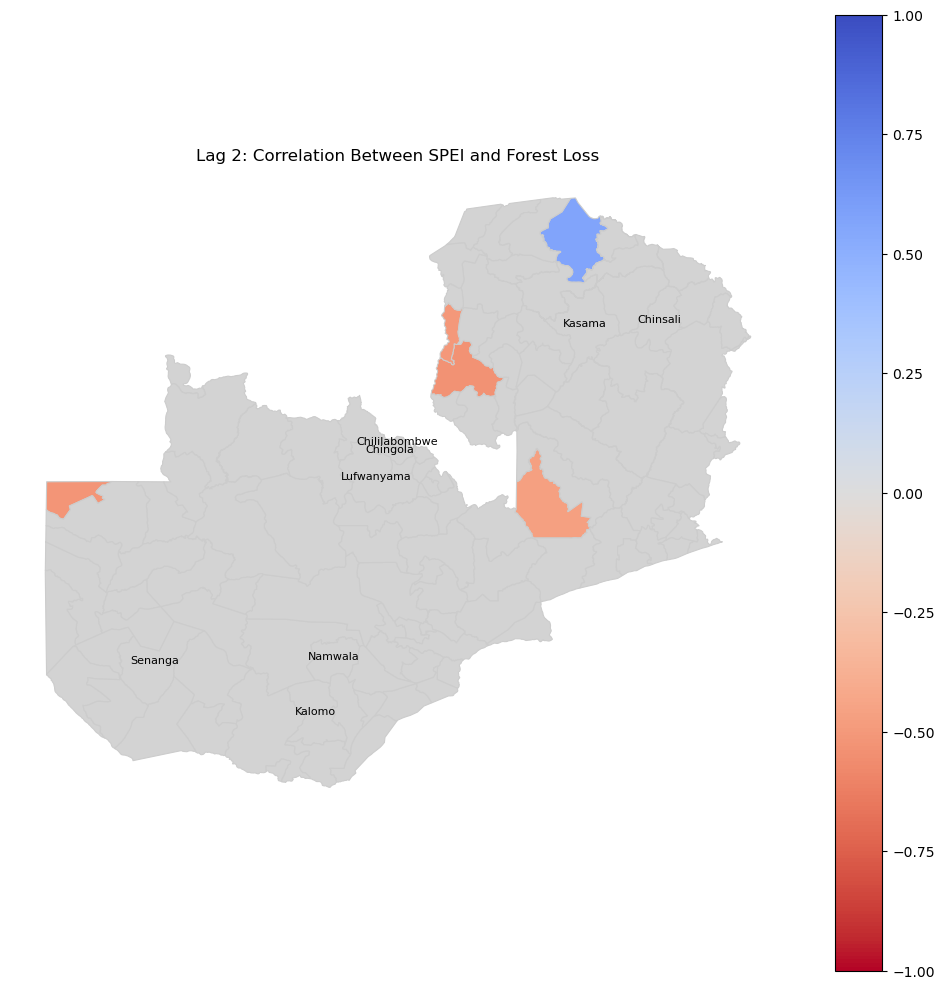

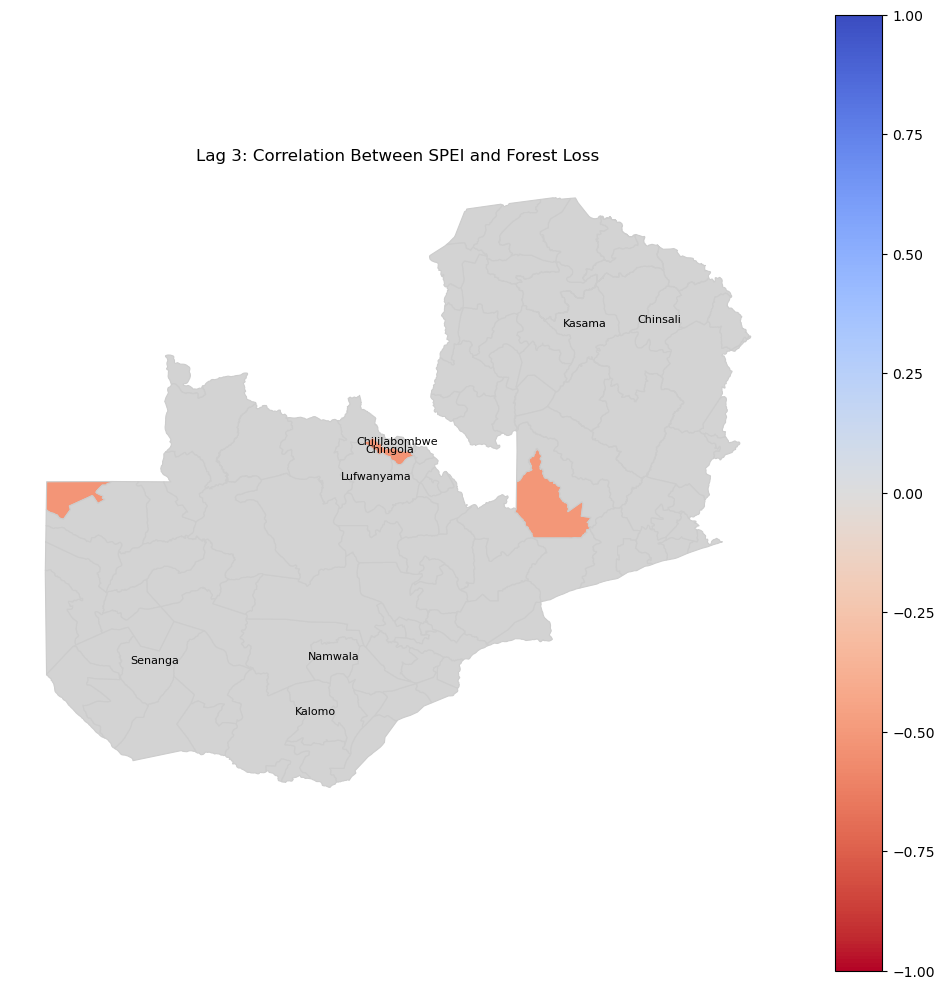

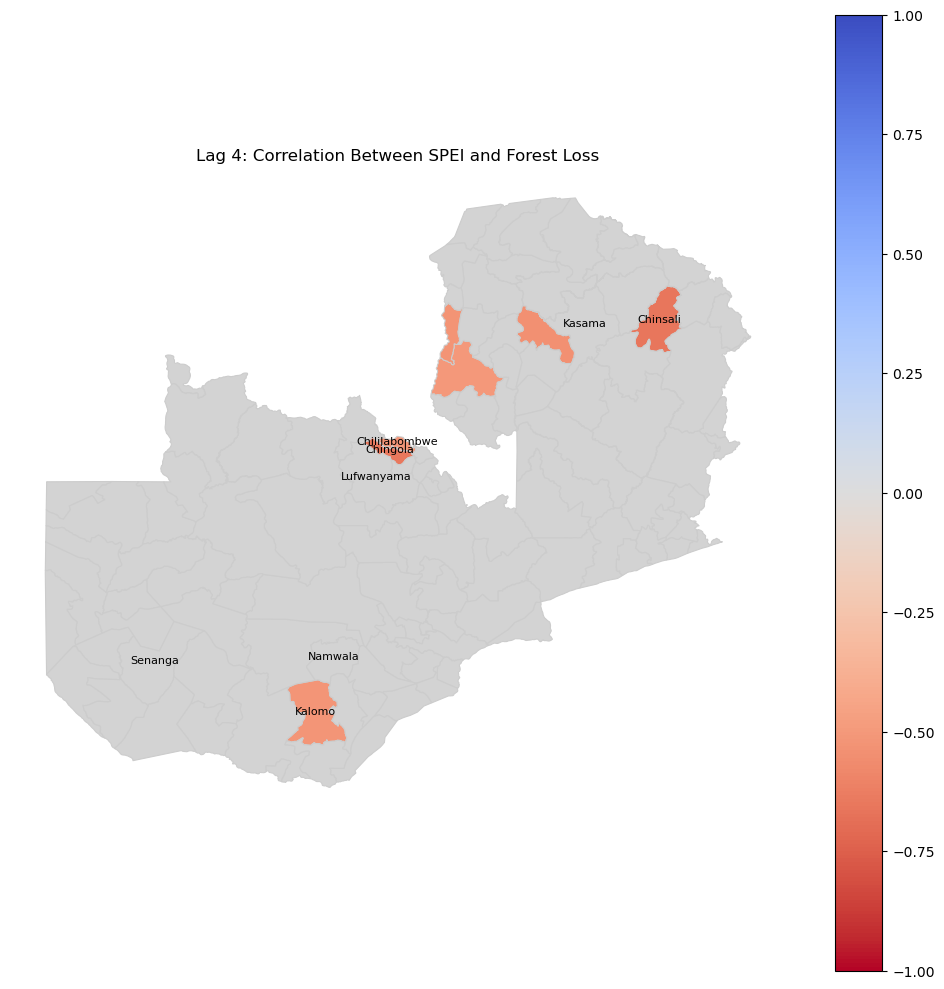

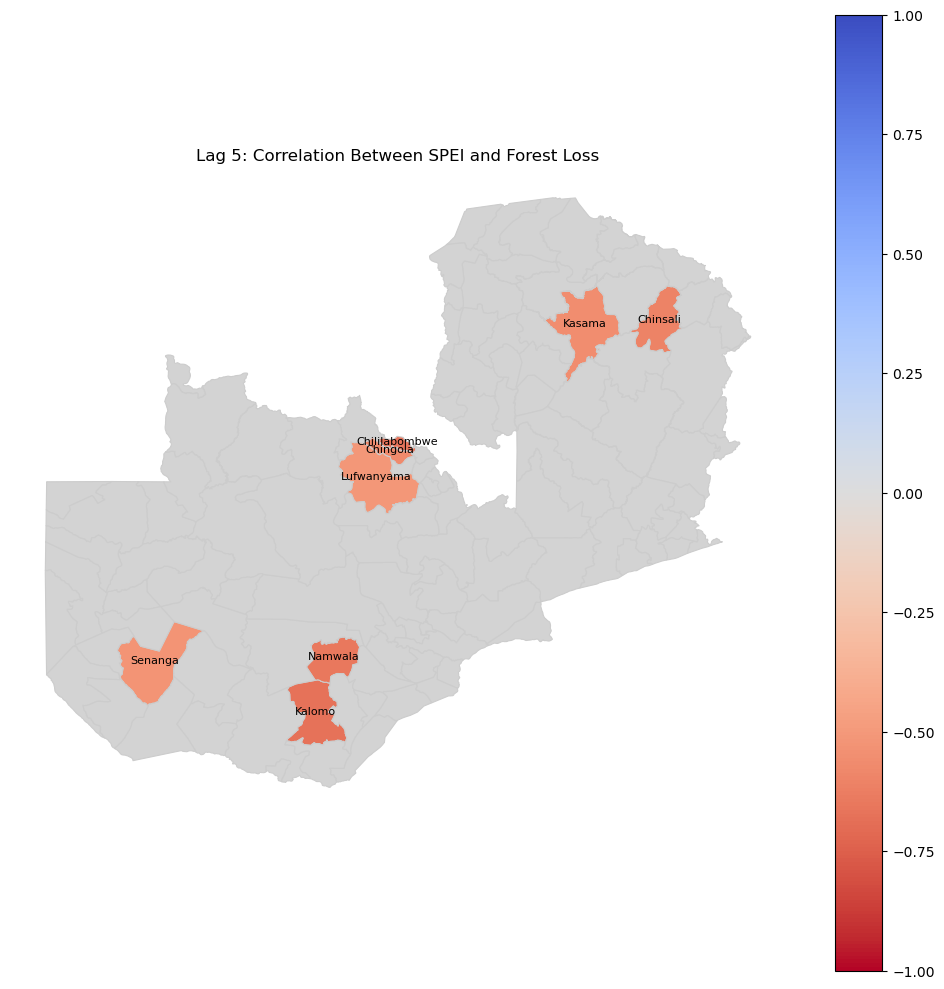

In [34]:
# introduce shapefile
zambia_gdf = gpd.read_file('Data/district.shp')

# rename district column for compatability
zambia_gdf = zambia_gdf.rename(columns={'NAME_2': 'district'})
zambia_gdf['district'] = zambia_gdf['district'].str.strip().str.title()

# full correlation data
correlation_data = pd.DataFrame(data)
correlation_data['district'] = correlation_data['district'].str.strip().str.title()


# loop through lags and create one map per lag
for lag in sorted(correlation_data['lag'].unique()):
    # subset for current lag
    lag_df = correlation_data[correlation_data['lag'] == lag]
    # merge with shapefile
    merged = zambia_gdf.merge(lag_df, on='district', how='left')
    # prepare to label districts 
districts_to_label = merged.loc[~merged['correlation'].isna(), 'district'].tolist()
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged.plot(
        column='correlation',
        cmap='coolwarm_r',
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        legend=True,
        vmin=-1,
        vmax=1,
        missing_kwds={
            'color': 'lightgrey',
            'label': 'No data',
        }
    )
    ax.set_title(f'Lag {lag}: Correlation Between SPEI and Forest Loss')
    ax.axis('off')
    plt.tight_layout()
    # add labels for selected districts
    for idx, row in merged.iterrows():
        if row['district'] in districts_to_label and row['geometry'] is not None:
            centroid = row['geometry'].centroid
            plt.text(
                centroid.x, centroid.y,
                row['district'],
                fontsize=8,
                ha='center',
                color='black'
            )
    plt.show()

## Growing Season SPEI vs. Total Forest Loss

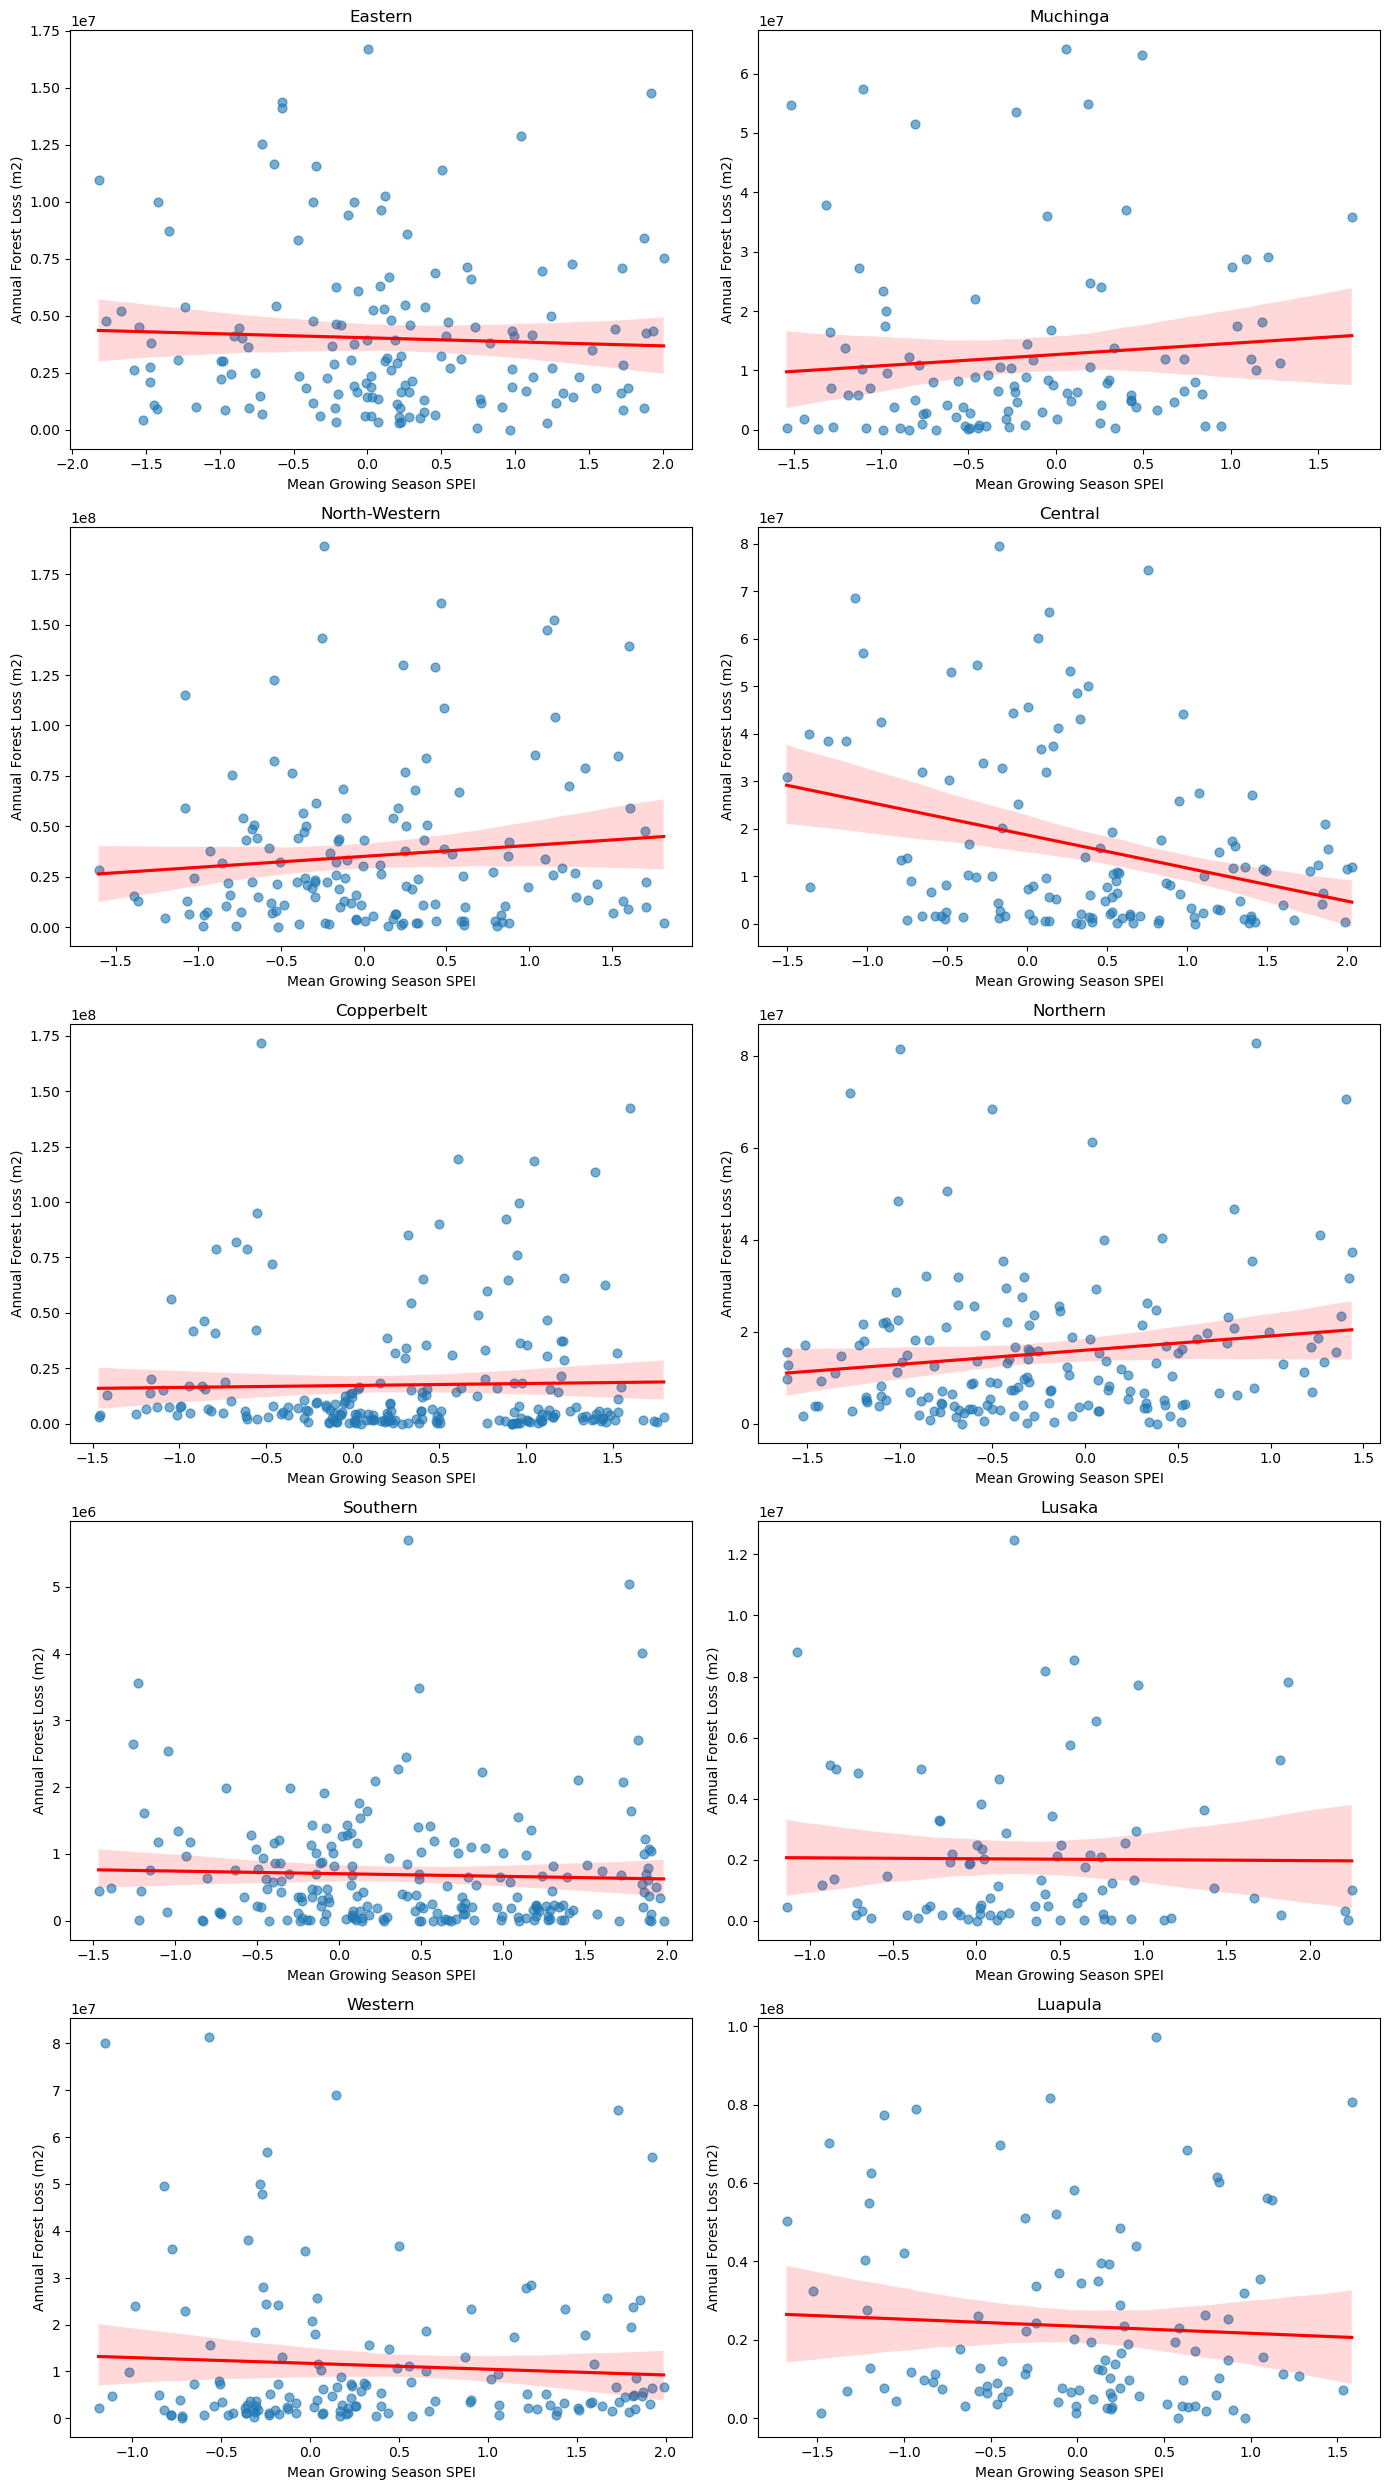

In [13]:
# drop rows with missing values (just to be safe)
plot_df = merged_df.dropna(subset=['district', 'mean_spei', 'loss_m2', 'province'])

# get unique provinces
provinces = plot_df['province'].unique()

# set up plot grid
cols = 2
rows = (len(provinces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
axes = axes.flatten()

# plot per province
for i, province in enumerate(provinces):
    ax = axes[i]
    province_data = plot_df[plot_df['province'] == province]

    sns.regplot(
        data=province_data,
        x='mean_spei',
        y='loss_m2',
        scatter=True,
        scatter_kws={'alpha': 0.6, 's': 40},
        line_kws={'color': 'red'},
        ax=ax
    )

    ax.set_title(province)
    ax.set_xlabel('Mean Growing Season SPEI')
    ax.set_ylabel('Annual Forest Loss (m2)')
    

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

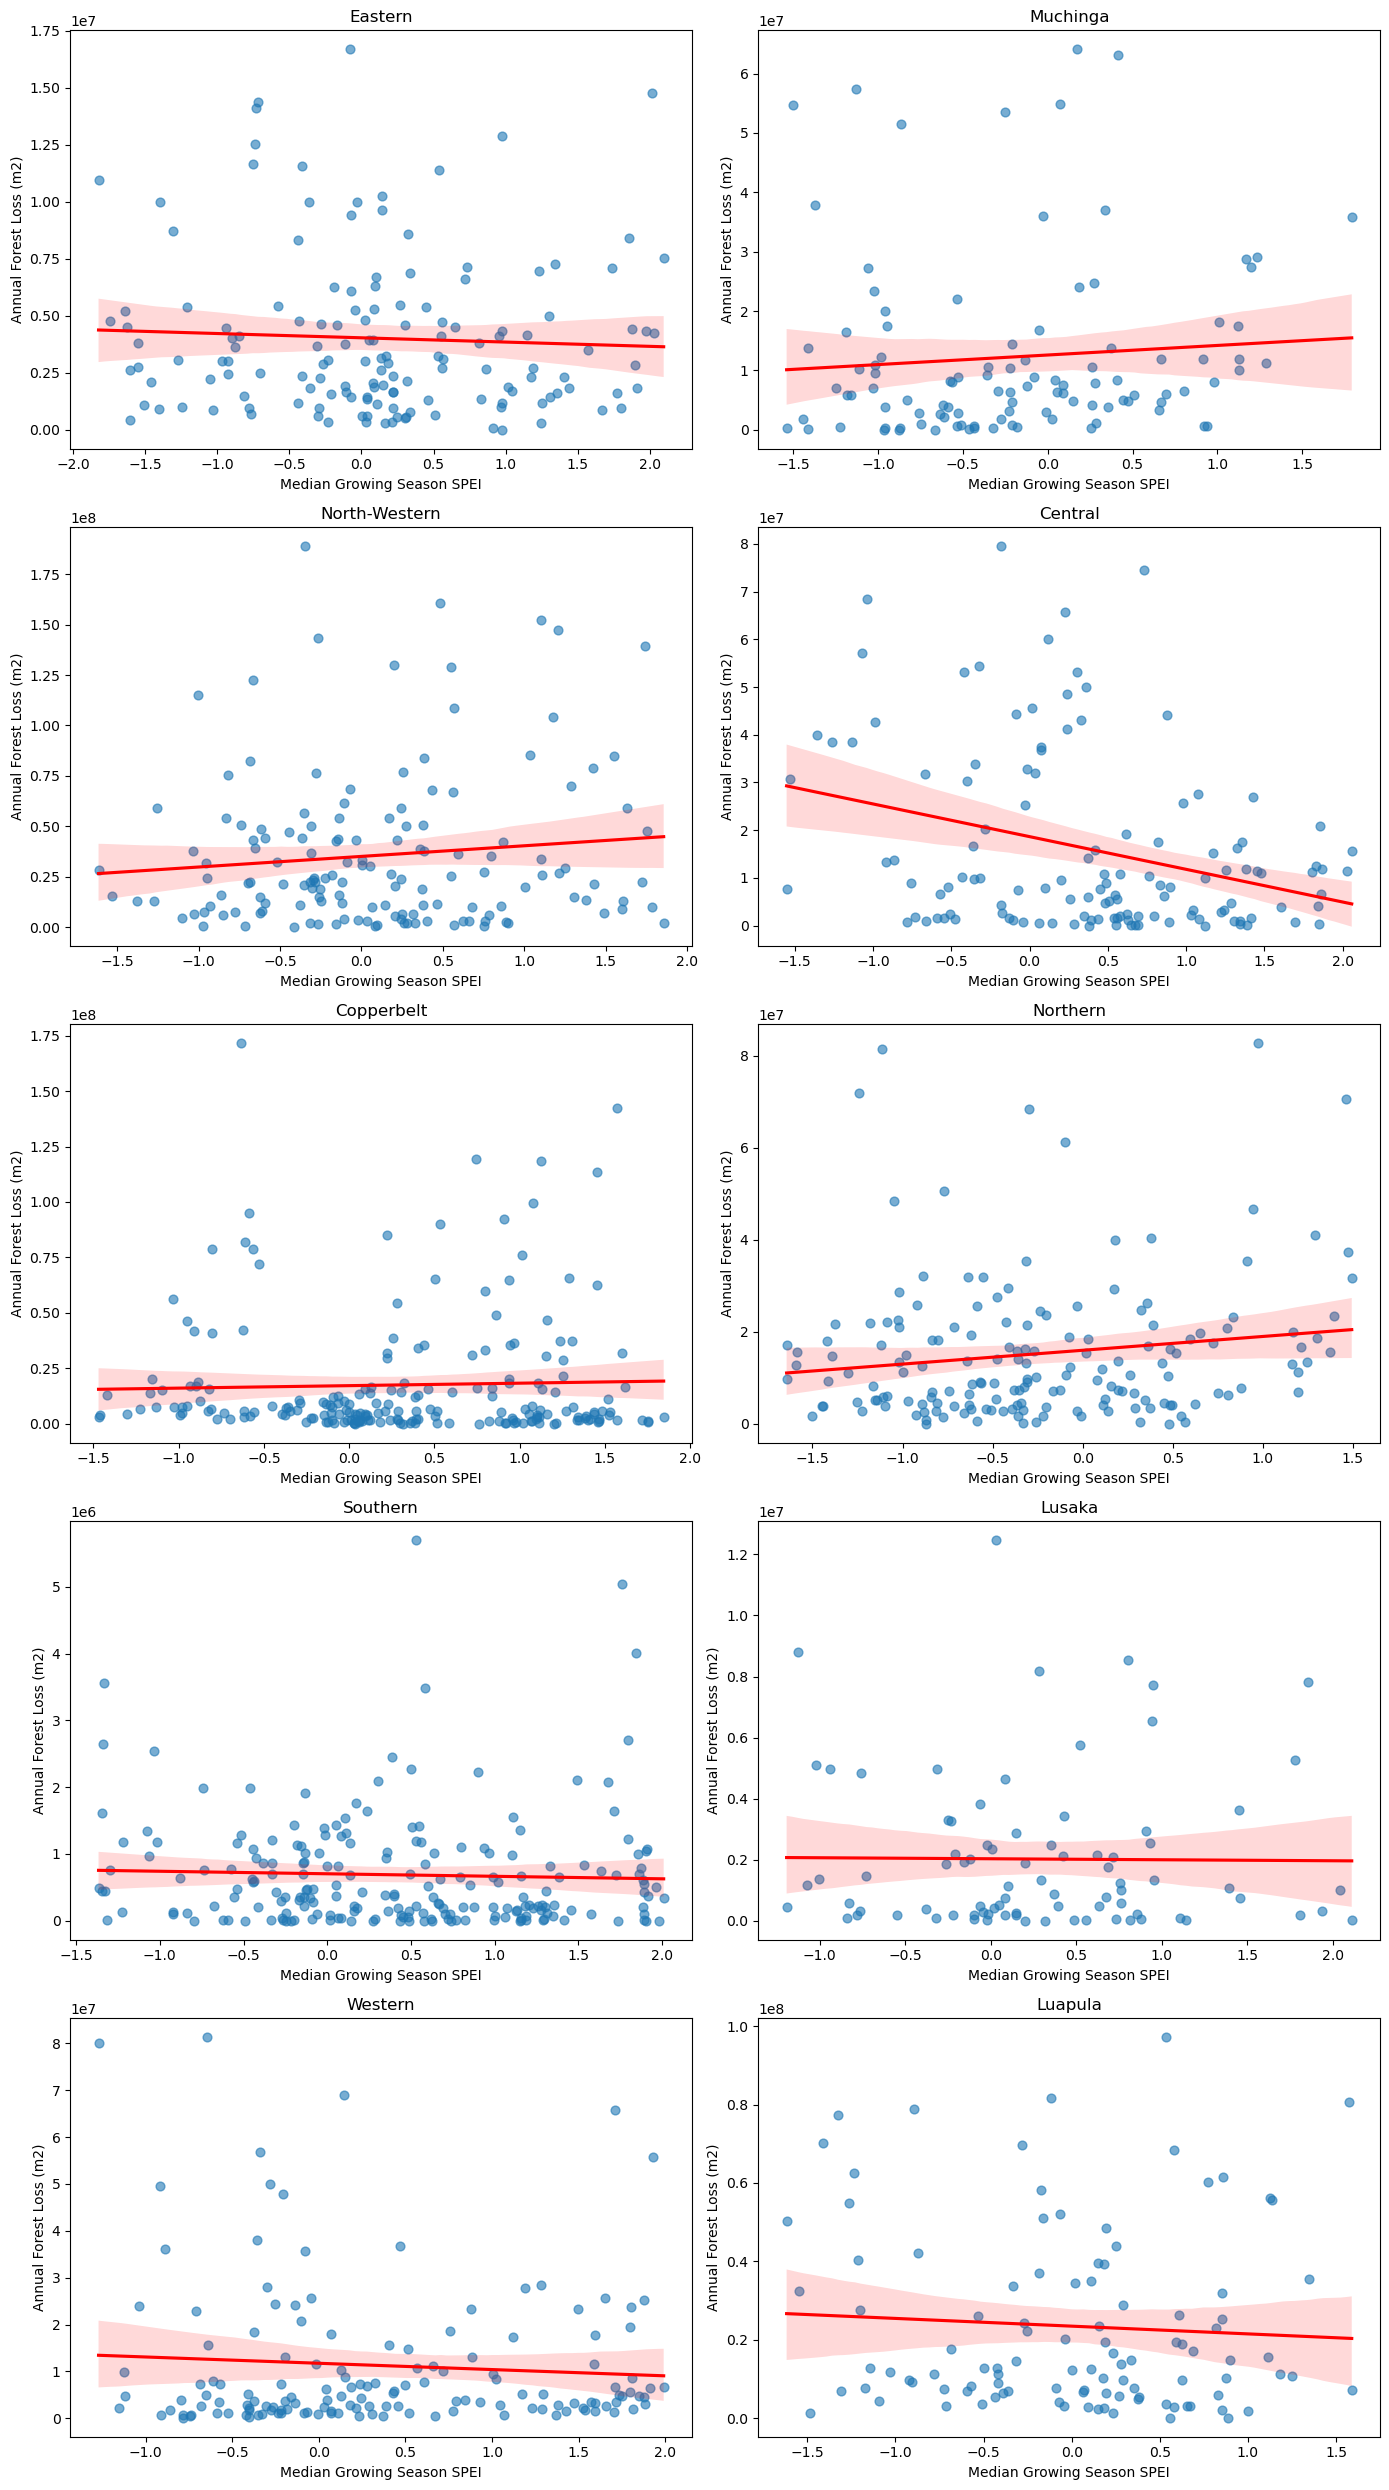

In [14]:
# drop rows with missing values (just to be safe)
plot_df = merged_df.dropna(subset=['district', 'median_spei', 'loss_m2', 'province'])

# get unique provinces
provinces = plot_df['province'].unique()

# set up plot grid
cols = 2
rows = (len(provinces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), squeeze=False)
axes = axes.flatten()

# plot per province
for i, province in enumerate(provinces):
    ax = axes[i]
    province_data = plot_df[plot_df['province'] == province]

    sns.regplot(
        data=province_data,
        x='median_spei',
        y='loss_m2',
        scatter=True,
        scatter_kws={'alpha': 0.6, 's': 40},
        line_kws={'color': 'red'},
        ax=ax
    )

    ax.set_title(province)
    ax.set_xlabel('Median Growing Season SPEI')
    ax.set_ylabel('Annual Forest Loss (m2)')
    

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## Code graveyard

In [ ]:
# drop missing values
plot_df = merged_df.dropna(subset=['district', 'year', 'mean_spei', 'percent_loss_annual'])
plot_df['year'] = plot_df['year'].astype(int)

# lag SPEI by 1 year within each district
plot_df['mean_spei_lag1'] = plot_df.groupby('district')['mean_spei'].shift(1)

# drop rows with NaNs after lagging
plot_df = plot_df.dropna(subset=['mean_spei_lag1'])

# get unique districts
districts = plot_df['district'].unique()

# set up plot grid
cols = 3
rows = (len(districts) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)
axes = axes.flatten()

# plot per district
for i, district in enumerate(districts):
    ax1 = axes[i]
    district_data = plot_df[plot_df['district'] == district].sort_values('year')
    
    # plot forest loss (left y-axis)
    ax1.plot(district_data['year'], district_data['percent_loss_annual'], label='Forest Loss (%)', color='green')
    ax1.set_ylabel('Forest Loss (%)', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    # plot lagged SPEI (right y-axis)
    ax2 = ax1.twinx()
    ax2.plot(district_data['year'], district_data['mean_spei_lag1'], label='Lagged SPEI (t-1)', color='red', linestyle='--')
    ax2.set_ylabel('Lagged SPEI (t-1)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title(district)
    ax1.set_xlabel('Year')

    # label x-axis every 5 years
    min_year = district_data['year'].min()
    max_year = district_data['year'].max()
    ax1.set_xticks(range(min_year, max_year + 1, 5))

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()